In this notebook we removed the variable which says wherer the customer has loyalty card or not (removed variables: "customer_name", "customer_birthdate", "loyalty_card_number", "loyalty_card"), minmax is used for the scaler

# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.impute import KNNImputer
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram
from minisom import MiniSom
import umap.umap_ as umap

from dendogram_func import plot_dendrogram
from silhouette import plot_silhouette
from dbscan_auxiliary_func import get_kdist_plot
from visualization_umap import visualize_dimensionality_reduction_umap
from radar_plot import create_radar_chart
from hierarchical_func import fit_and_predict_clusters

C:\Users\joaof\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Importing the datasets and looking ate them

In [2]:
customer_info = pd.read_csv("customer_info.csv", index_col = "customer_id", parse_dates=['customer_birthdate']).drop(columns = "Unnamed: 0")

C:\Users\joaof\AppData\Local\Temp\ipykernel_4740\3321492438.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  customer_info = pd.read_csv("customer_info.csv", index_col = "customer_id", parse_dates=['customer_birthdate']).drop(columns = "Unnamed: 0")


In [4]:
customer_info.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43631 entries, 39634 to 5120
Data columns (total 24 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   customer_name                            43631 non-null  object        
 1   customer_gender                          43631 non-null  object        
 2   customer_birthdate                       43631 non-null  datetime64[ns]
 3   kids_home                                43107 non-null  float64       
 4   teens_home                               42610 non-null  float64       
 5   number_complaints                        42977 non-null  float64       
 6   distinct_stores_visited                  42322 non-null  float64       
 7   lifetime_spend_groceries                 43631 non-null  float64       
 8   lifetime_spend_electronics               43631 non-null  float64       
 9   typical_hour                             

In [5]:
customer_info.iloc[:,20:22].info()

<class 'pandas.core.frame.DataFrame'>
Index: 43631 entries, 39634 to 5120
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   year_first_transaction  43631 non-null  float64
 1   loyalty_card_number     24654 non-null  float64
dtypes: float64(2)
memory usage: 1022.6 KB


In [6]:
customer_info.duplicated().sum()

0

# Some visualizations

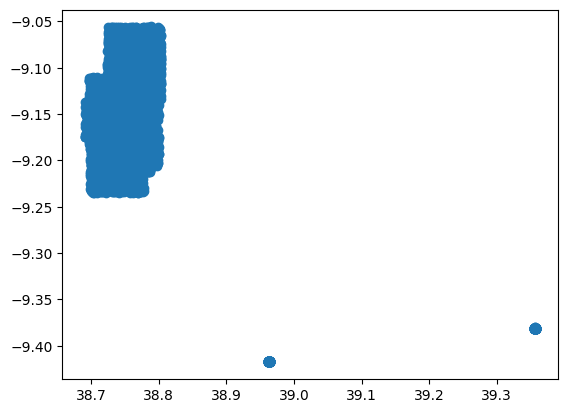

In [10]:
#Plotting longitude and latitude
plt.scatter(x = customer_info["latitude"], y= customer_info["longitude"])
plt.show()

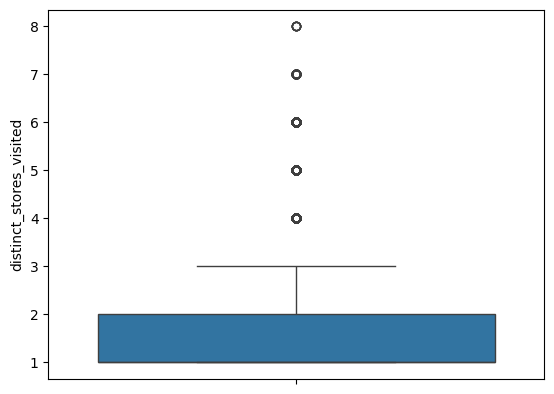

In [11]:
sns.boxplot(data = customer_info, y = "distinct_stores_visited")
plt.show()

In [12]:
customer_info[["lifetime_spend_fish"]]

lifetime_spend_fish
customer_id                     
39634                     4056.0
43460                     1925.0
23937                     2347.0
2431                       151.0
10090                      172.0
...                          ...
48487                     3779.0
24856                     3893.0
21373                      142.0
19527                        0.0
5120                      1221.0

[43631 rows x 1 columns]

In [13]:
customer_info[["lifetime_spend_fish"]].value_counts()

lifetime_spend_fish
1.0                    3298
0.0                    2624
2.0                     865
3.0                     101
318.0                    42
                       ... 
3079.0                    1
3077.0                    1
3067.0                    1
3065.0                    1
50381.0                   1
Name: count, Length: 4770, dtype: int64

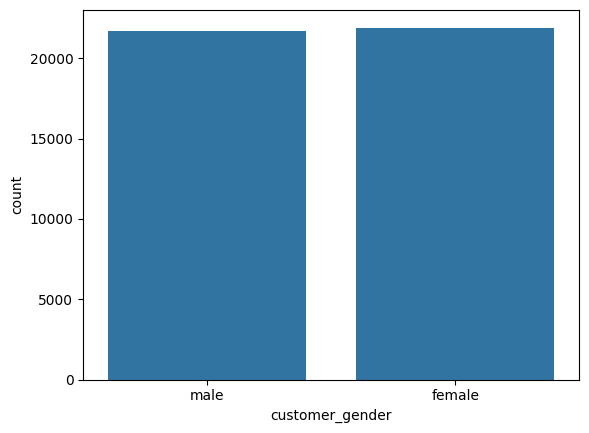

In [14]:
sns.countplot(x='customer_gender', data=customer_info)
plt.show()

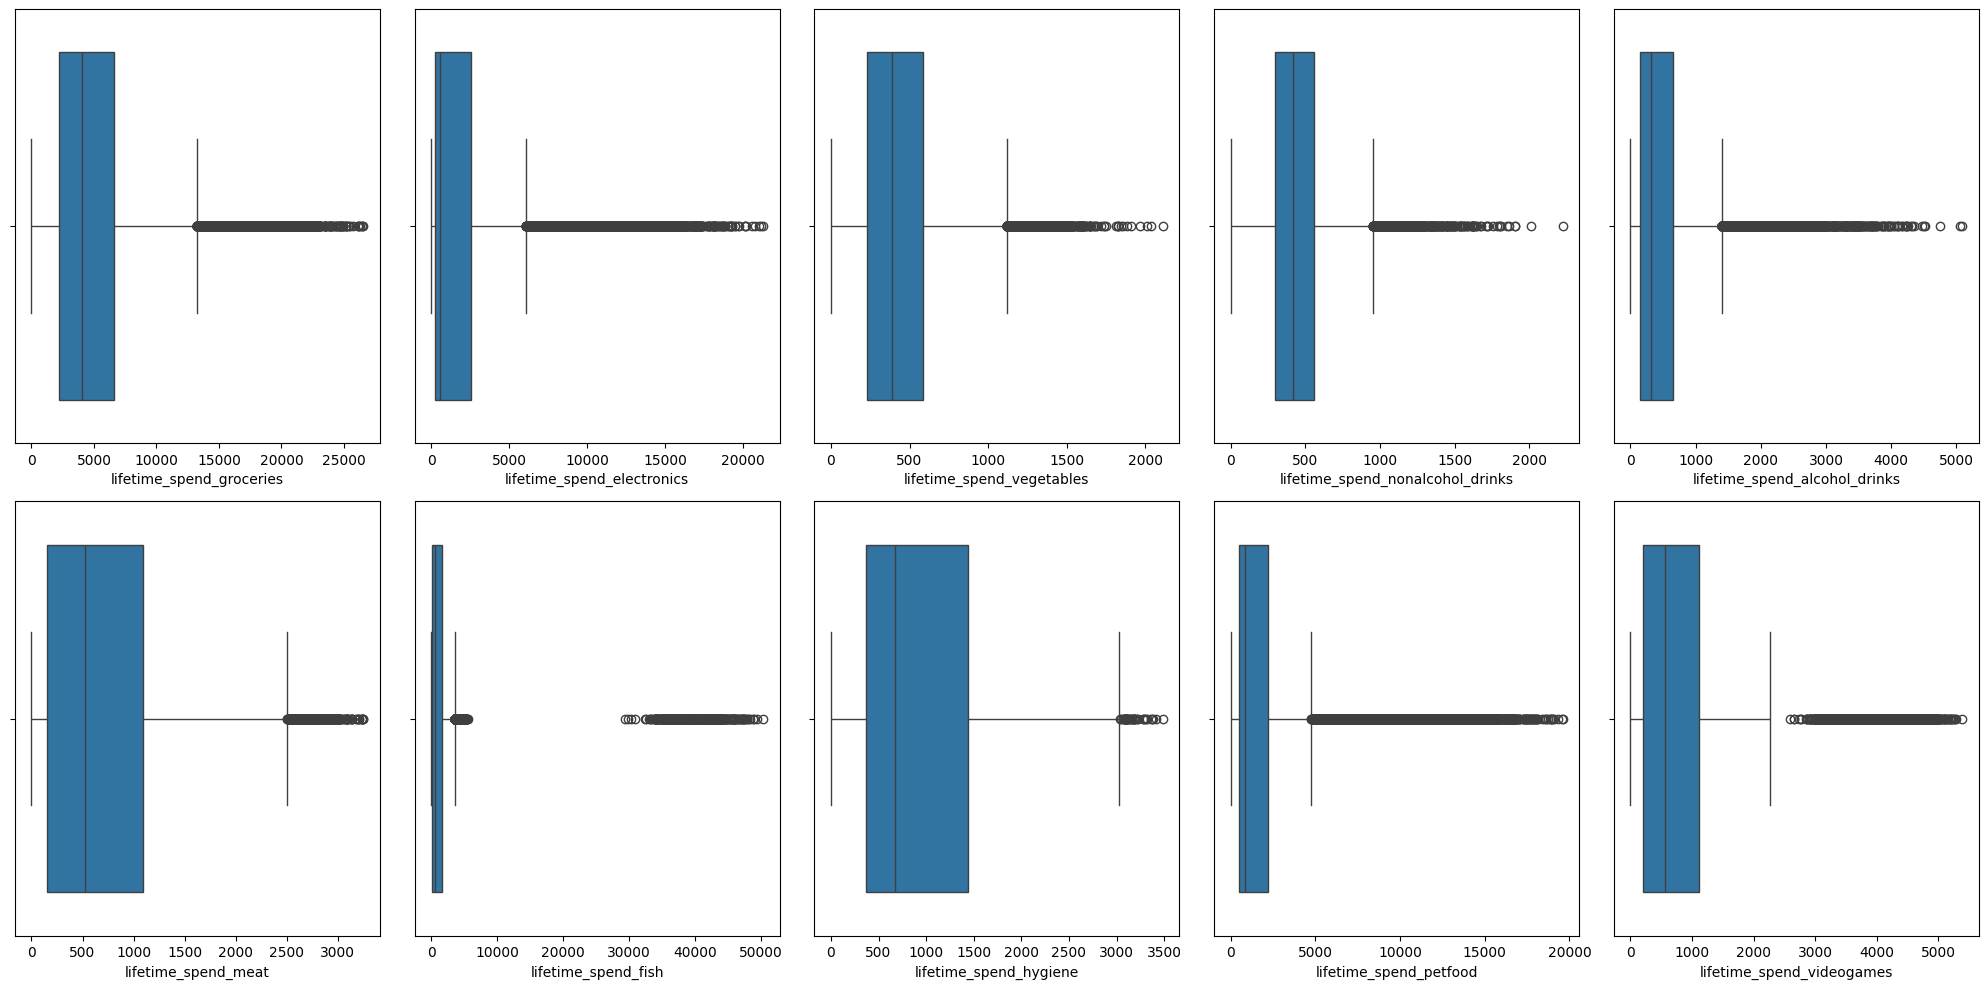

In [15]:
columns = ['lifetime_spend_groceries','lifetime_spend_electronics', 'lifetime_spend_vegetables',
           'lifetime_spend_nonalcohol_drinks', 'lifetime_spend_alcohol_drinks',
            'lifetime_spend_meat', 'lifetime_spend_fish', 'lifetime_spend_hygiene',
             'lifetime_spend_petfood', 'lifetime_spend_videogames']
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20,10))
for i, column in enumerate(columns):
        if i// 5 == 0:
                sns.boxplot(x=customer_info[column], ax=axes[0][i])
        else:
                sns.boxplot(x=customer_info[column], ax=axes[1][i-5])
plt.tight_layout()   
plt.show()

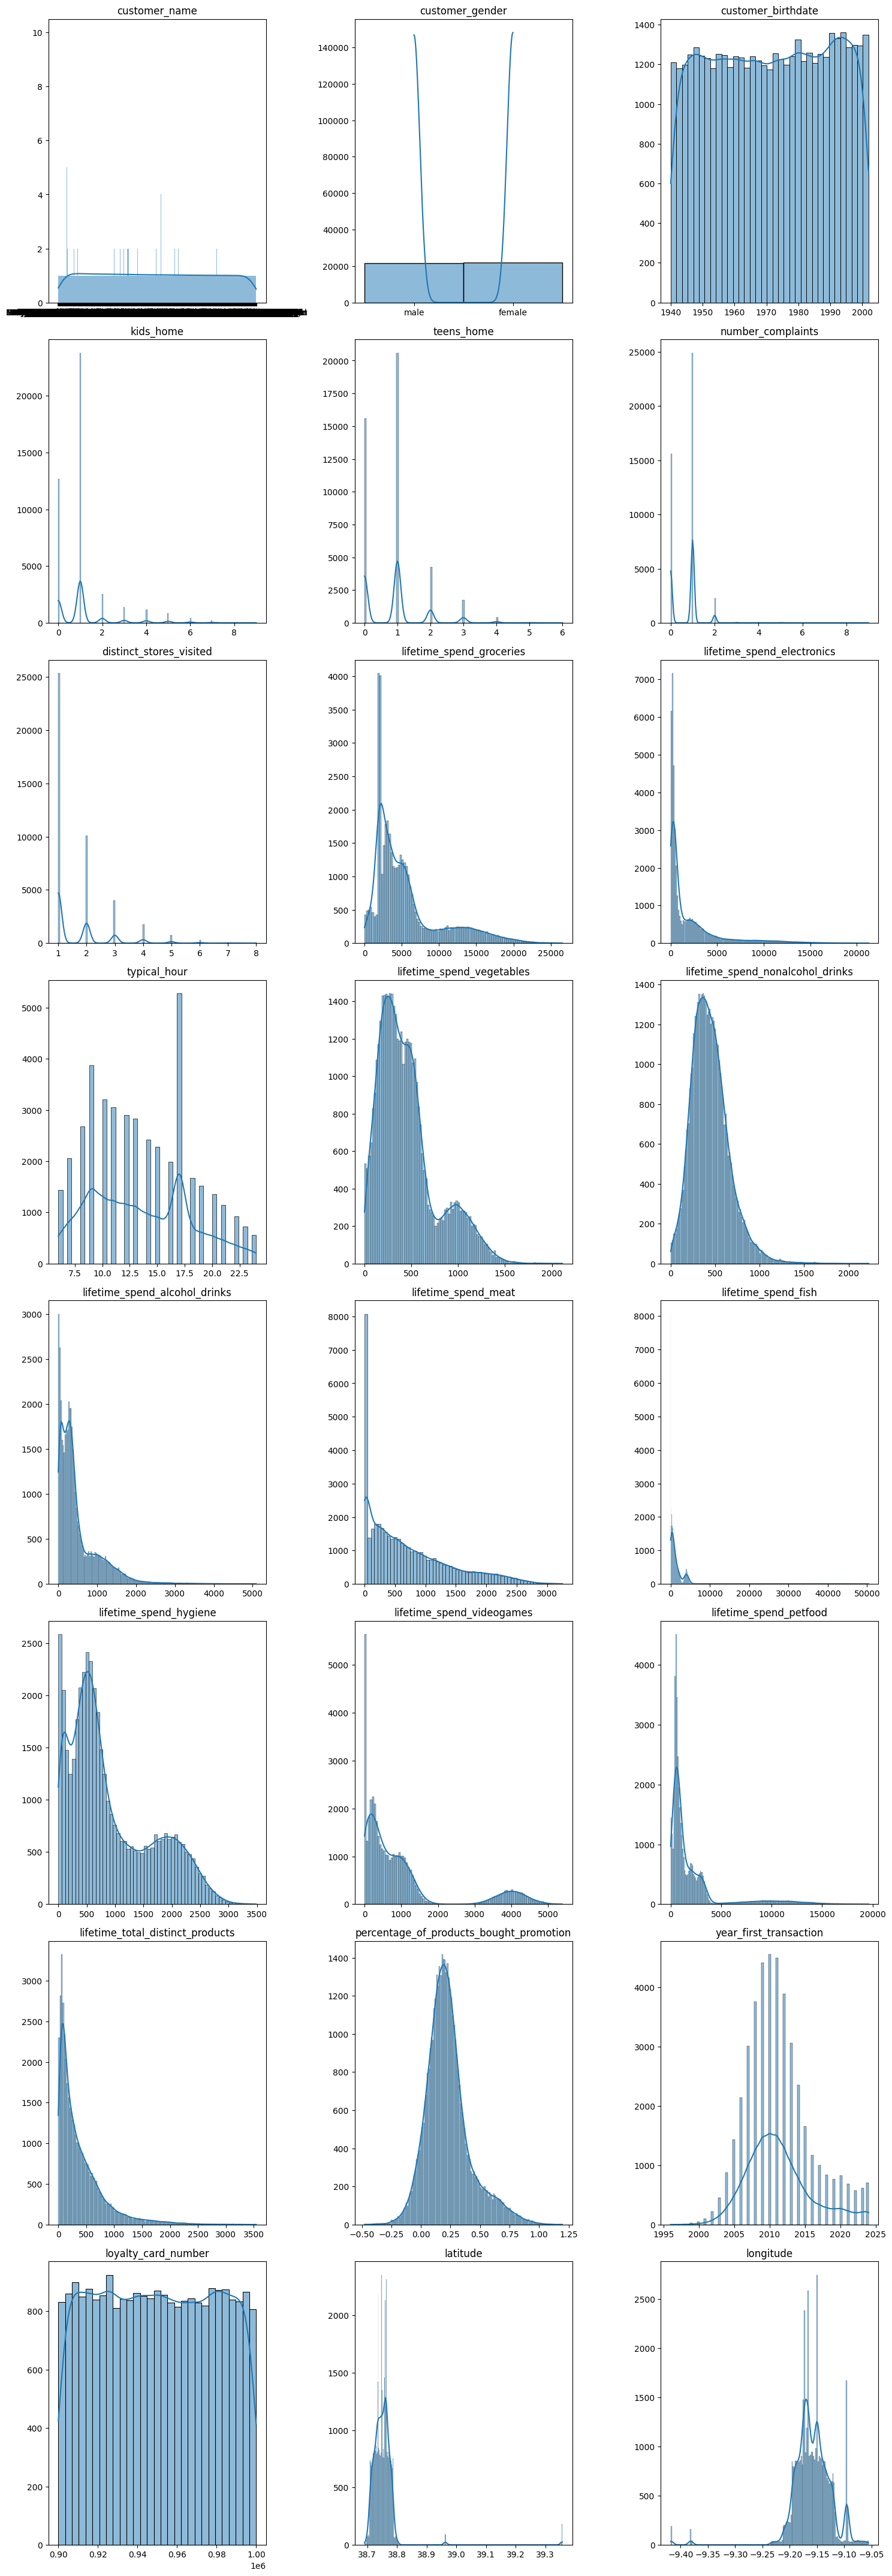

In [16]:
columns_to_visualize = customer_info.columns

# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=len(columns_to_visualize)//3 + 1, ncols=3, figsize=(15, len(columns_to_visualize) * 2))

axes = axes.flatten()

# Loop through the columns and create a plot for each
for i, column in enumerate(columns_to_visualize):
    sns.histplot(customer_info[column], ax=axes[i], kde=True)
    axes[i].set_title(column)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])


plt.tight_layout()
plt.show()


# Dealing with some outliers (creating a cluster of just fishermen who spend a lot on fish)

In [3]:
customer_info[customer_info["lifetime_spend_fish"] >6000]

customer_name customer_gender  customer_birthdate  kids_home  \
customer_id                                                                     
48086          Charles`s Fishy            male 1966-09-04 09:18:00        0.0   
31838           Ursula`s Fishy          female 1963-09-20 15:37:00        0.0   
41519          Lindsay`s Fishy          female 1956-07-27 18:05:00        0.0   
41076            Carol`s Fishy          female 1942-07-18 08:53:00        0.0   
43120          Rosetta`s Fishy          female 1980-03-30 19:34:00        0.0   
...                        ...             ...                 ...        ...   
24463        Stephanie`s Fishy          female 1956-04-10 18:50:00        0.0   
12487          Derrick`s Fishy            male 1973-02-20 00:04:00        0.0   
14727            Tyler`s Fishy            male 1985-01-10 03:28:00        0.0   
46634           Kendra`s Fishy          female 1945-11-02 11:33:00        0.0   
20914             Anna`s Fishy          female 1994-08-26 03:33:00        0.0   

             teens_home  number_complaints  distinct_stores_visited  \
customer_id                                                           
48086               0.0                1.0                      1.0   
31838               0.0                1.0                      1.0   
41519               0.0                0.0                      1.0   
41076               0.0                0.0                      1.0   
43120               0.0                1.0                      1.0   
...                 ...                ...                      ...   
24463               0.0                1.0                      1.0   
12487               0.0                0.0                      1.0   
14727               0.0                1.0                      1.0   
46634               1.0                0.0                      1.0   
20914               0.0                1.0                      1.0   

             lifetime_spend_groceries  lifetime_spend_electronics  \
customer_id                                                         
48086                         14998.0                        49.0   
31838                         13837.0                       104.0   
41519                         14680.0                       167.0   
41076                         15110.0                       357.0   
43120                         16945.0                       200.0   
...                               ...                         ...   
24463                         16382.0                        77.0   
12487                         17416.0                       170.0   
14727                         14184.0                       158.0   
46634                         14685.0                        17.0   
20914                         14060.0                        13.0   

             typical_hour  ...  lifetime_spend_fish  lifetime_spend_hygiene  \
customer_id                ...                                                
48086                 7.0  ...              48432.0                    82.0   
31838                 9.0  ...              45651.0                   101.0   
41519                 9.0  ...              38525.0                   148.0   
41076                12.0  ...              34035.0                    80.0   
43120                 9.0  ...              39154.0                    20.0   
...                   ...  ...                  ...                     ...   
24463                17.0  ...              40584.0                   136.0   
12487                17.0  ...              40936.0                    72.0   
14727                 9.0  ...              40034.0                   101.0   
46634                17.0  ...              49025.0                   118.0   
20914                 9.0  ...              44585.0                    77.0   

             lifetime_spend_videogames  lifetime_spend_petfood  \
customer_id                                    

In [4]:
out_fishermen = customer_info[customer_info["customer_name"].str.contains("Fishy")]

In [5]:
customer_info['Age'] = (pd.to_datetime('2024-05-01') - customer_info['customer_birthdate']).dt.days // 365.25
customer_info

customer_name customer_gender  customer_birthdate  \
customer_id                                                           
39634               David Frink            male 1964-05-15 22:34:00   
43460             Belinda Terry          female 1988-03-26 23:06:00   
23937             Evelyn Calico          female 1969-04-13 18:07:00   
2431                Ora Boggess          female 1941-06-15 03:26:00   
10090             Lonnie Hopson            male 2001-12-18 03:03:00   
...                         ...             ...                 ...   
48487           Amelia Crawford          female 1983-08-28 11:43:00   
24856              Silvia Ramos          female 1992-09-21 19:16:00   
21373             Addie Coronel          female 1994-02-20 05:58:00   
19527            Msc. Mary Ross          female 1989-08-06 16:39:00   
5120         Bsc. Milton Friend            male 1957-06-19 10:53:00   

             kids_home  teens_home  number_complaints  \
customer_id                                             
39634              1.0         1.0                1.0   
43460              1.0         0.0                1.0   
23937              0.0         1.0                1.0   
2431               0.0         0.0                0.0   
10090              0.0         0.0                0.0   
...                ...         ...                ...   
48487              1.0         1.0                0.0   
24856              1.0         1.0                1.0   
21373              0.0         0.0                0.0   
19527              1.0         0.0                1.0   
5120               2.0         0.0                2.0   

             distinct_stores_visited  lifetime_spend_groceries  \
customer_id                                                      
39634                            2.0                   18306.0   
43460                            2.0                    5015.0   
23937                            3.0                    3097.0   
2431                             1.0                   10825.0   
10090                            1.0                     697.0   
...                              ...                       ...   
48487                            1.0                    7189.0   
24856                            1.0                   11238.0   
21373                            1.0                    6059.0   
19527                            1.0                    3098.0   
5120                             1.0                    6869.0   

             lifetime_spend_electronics  typical_hour  ...  \
customer_id                                            ...   
39634                            7106.0          17.0  ...   
43460                            1334.0           8.0  ...   
23937                            4073.0          10.0  ...   
2431                              207.0          17.0  ...   
10090                             570.0           NaN  ...   
...                                 ...           ...  ...   
48487                            6293.0          17.0  ...   
24856                           11490.0          12.0  ...   
21373                             241.0          12.0  ...   
19527                             425.0           6.0  ...   
5120                             1554.0          10.0  ...   

             lifetime_spend_hygiene  lifetime_spend_videogames  \
customer_id                                                      
39634                        2174.0                     3946.0   
43460                        2115.0                     1028.0   
23937                        1306.0                     1504.0   
2431                           53.0                        0.0   
10090                         587.0                      223.0   
...                             ...                        ...   
48487                        1748.0                     4387.0   
24856                        1621.0                     3831.0   
21373                     

In [6]:
customer_info

customer_name customer_gender  customer_birthdate  \
customer_id                                                           
39634               David Frink            male 1964-05-15 22:34:00   
43460             Belinda Terry          female 1988-03-26 23:06:00   
23937             Evelyn Calico          female 1969-04-13 18:07:00   
2431                Ora Boggess          female 1941-06-15 03:26:00   
10090             Lonnie Hopson            male 2001-12-18 03:03:00   
...                         ...             ...                 ...   
48487           Amelia Crawford          female 1983-08-28 11:43:00   
24856              Silvia Ramos          female 1992-09-21 19:16:00   
21373             Addie Coronel          female 1994-02-20 05:58:00   
19527            Msc. Mary Ross          female 1989-08-06 16:39:00   
5120         Bsc. Milton Friend            male 1957-06-19 10:53:00   

             kids_home  teens_home  number_complaints  \
customer_id                                             
39634              1.0         1.0                1.0   
43460              1.0         0.0                1.0   
23937              0.0         1.0                1.0   
2431               0.0         0.0                0.0   
10090              0.0         0.0                0.0   
...                ...         ...                ...   
48487              1.0         1.0                0.0   
24856              1.0         1.0                1.0   
21373              0.0         0.0                0.0   
19527              1.0         0.0                1.0   
5120               2.0         0.0                2.0   

             distinct_stores_visited  lifetime_spend_groceries  \
customer_id                                                      
39634                            2.0                   18306.0   
43460                            2.0                    5015.0   
23937                            3.0                    3097.0   
2431                             1.0                   10825.0   
10090                            1.0                     697.0   
...                              ...                       ...   
48487                            1.0                    7189.0   
24856                            1.0                   11238.0   
21373                            1.0                    6059.0   
19527                            1.0                    3098.0   
5120                             1.0                    6869.0   

             lifetime_spend_electronics  typical_hour  ...  \
customer_id                                            ...   
39634                            7106.0          17.0  ...   
43460                            1334.0           8.0  ...   
23937                            4073.0          10.0  ...   
2431                              207.0          17.0  ...   
10090                             570.0           NaN  ...   
...                                 ...           ...  ...   
48487                            6293.0          17.0  ...   
24856                           11490.0          12.0  ...   
21373                             241.0          12.0  ...   
19527                             425.0           6.0  ...   
5120                             1554.0          10.0  ...   

             lifetime_spend_hygiene  lifetime_spend_videogames  \
customer_id                                                      
39634                        2174.0                     3946.0   
43460                        2115.0                     1028.0   
23937                        1306.0                     1504.0   
2431                           53.0                        0.0   
10090                         587.0                      223.0   
...                             ...                        ...   
48487                        1748.0                     4387.0   
24856                        1621.0                     3831.0   
21373                     

# Rebuilding loyalty card and gender variables

In [7]:
customer_info["loyalty_card"] = customer_info["loyalty_card_number"].notnull().astype(int)

In [8]:
customer_info["loyalty_card"]

customer_id
39634    0
43460    0
23937    1
2431     1
10090    1
        ..
48487    0
24856    1
21373    0
19527    1
5120     1
Name: loyalty_card, Length: 43631, dtype: int32

In [9]:
customer_info = pd.get_dummies(customer_info, columns= ["customer_gender"], drop_first= True)

In [10]:
customer_info["customer_gender_male"] = customer_info["customer_gender_male"].apply(lambda x: 1 if x == True else 0)

In [11]:
customer_info["customer_gender_male"]

customer_id
39634    1
43460    0
23937    0
2431     0
10090    1
        ..
48487    0
24856    0
21373    0
19527    0
5120     1
Name: customer_gender_male, Length: 43631, dtype: int64

In [12]:
# Dataframe only for clustering and other preprocessing(for interpretation use customer_info)
customers = customer_info[~customer_info["customer_name"].str.contains("Fishy")]

In [13]:
customers = customers.drop(columns = ["customer_name", "customer_birthdate", "loyalty_card_number", "loyalty_card"])

# Standardizing Variables

In [14]:
mm = MinMaxScaler().fit(customers)
customers_mm = mm.transform(customers)

In [15]:
customers_scalled = pd.DataFrame(customers_mm, columns = customers.columns, index = customers.index)

In [16]:
customers_scalled.head()

kids_home  teens_home  number_complaints  \
customer_id                                             
39634         0.111111    0.166667           0.111111   
43460         0.111111    0.000000           0.111111   
23937         0.000000    0.166667           0.111111   
2431          0.000000    0.000000           0.000000   
10090         0.000000    0.000000           0.000000   

             distinct_stores_visited  lifetime_spend_groceries  \
customer_id                                                      
39634                       0.142857                  0.689440   
43460                       0.142857                  0.188875   
23937                       0.285714                  0.116639   
2431                        0.000000                  0.407691   
10090                       0.000000                  0.026250   

             lifetime_spend_electronics  typical_hour  \
customer_id                                             
39634                          0.334038      0.611111   
43460                          0.062709      0.111111   
23937                          0.191463      0.222222   
2431                           0.009731      0.611111   
10090                          0.026795           NaN   

             lifetime_spend_vegetables  lifetime_spend_nonalcohol_drinks  \
customer_id                                                                
39634                         0.229167                          0.271583   
43460                         0.162879                          0.168165   
23937                         0.142519                          0.383094   
2431                          0.072443                          0.113309   
10090                         0.003788                          0.014838   

             lifetime_spend_alcohol_drinks  ...  lifetime_spend_hygiene  \
customer_id                                 ...                           
39634                             0.185229  ...                0.623459   
43460                             0.239049  ...                0.606539   
23937                             0.340012  ...                0.374534   
2431                              0.011786  ...                0.015199   
10090                             0.556472  ...                0.168340   

             lifetime_spend_videogames  lifetime_spend_petfood  \
customer_id                                                      
39634                         0.732232                0.128291   
43460                         0.190759                0.101398   
23937                         0.279087                0.102980   
2431                          0.000000                0.211012   
10090                         0.041381                0.003266   

             lifetime_total_distinct_products  \
customer_id                                     
39634                                0.009029   
43460                                0.724041   
23937                                0.361738   
2431                                 0.019752   
10090                                0.001129   

             percentage_of_products_bought_promotion  year_first_transaction  \
customer_id                                                                    
39634                                       0.328503                0.500000   
43460                                       0.408523                0.642857   
23937                                       0.366693                0.464286   
2431                                        0.414270                0.392857   
10090                                       0.393475                1.000000   

             latitude  longitude       Age  customer_gender_male  
customer_id                                                       
39634        0.397470   0.478999  0.596774                   1.0  
43460        0.636523   0.413765  0.225806                   0.0  
23937        0.236664   0.389840  0.532258             

<Axes: >

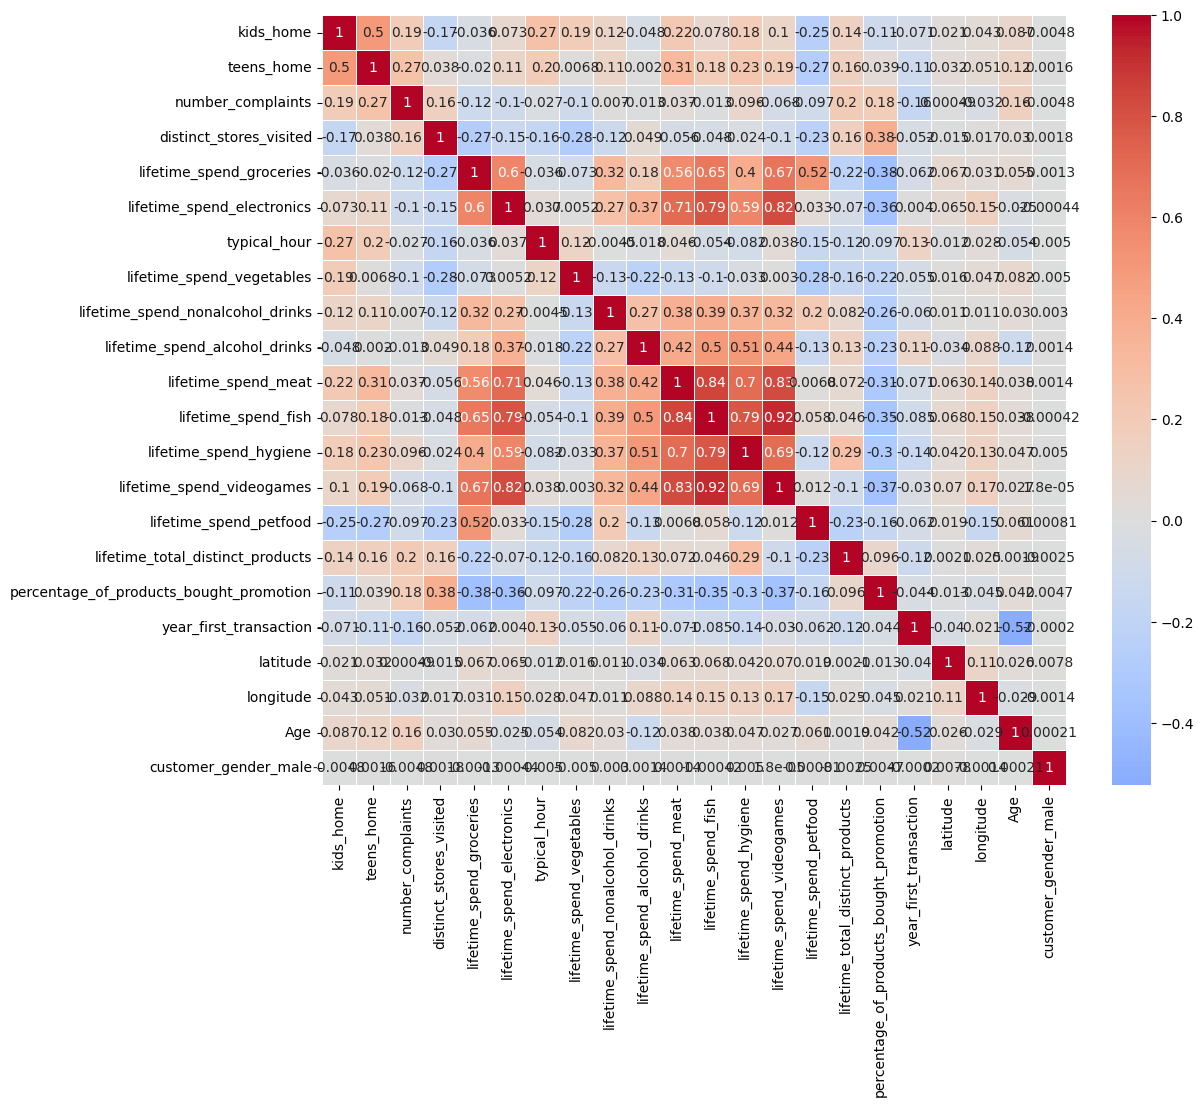

In [17]:
correlation_matrix = customers_scalled.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))
    
# Draw the heatmap with the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5)

Fish with high correlation with a lot of variables so we tried to remove it but got worse results

# Imputing Missing Values

In [18]:
knn = KNNImputer(n_neighbors= 5).fit(customers_scalled)

In [19]:
customers_imputed = knn.transform(customers_scalled)

In [20]:
cust_prepoc= pd.DataFrame(customers_imputed, columns = customers.columns, index = customers.index)

In [21]:
cust_prepoc.head()

kids_home  teens_home  number_complaints  \
customer_id                                             
39634         0.111111    0.166667           0.111111   
43460         0.111111    0.000000           0.111111   
23937         0.000000    0.166667           0.111111   
2431          0.000000    0.000000           0.000000   
10090         0.000000    0.000000           0.000000   

             distinct_stores_visited  lifetime_spend_groceries  \
customer_id                                                      
39634                       0.142857                  0.689440   
43460                       0.142857                  0.188875   
23937                       0.285714                  0.116639   
2431                        0.000000                  0.407691   
10090                       0.000000                  0.026250   

             lifetime_spend_electronics  typical_hour  \
customer_id                                             
39634                          0.334038      0.611111   
43460                          0.062709      0.111111   
23937                          0.191463      0.222222   
2431                           0.009731      0.611111   
10090                          0.026795      0.766667   

             lifetime_spend_vegetables  lifetime_spend_nonalcohol_drinks  \
customer_id                                                                
39634                         0.229167                          0.271583   
43460                         0.162879                          0.168165   
23937                         0.142519                          0.383094   
2431                          0.072443                          0.113309   
10090                         0.003788                          0.014838   

             lifetime_spend_alcohol_drinks  ...  lifetime_spend_hygiene  \
customer_id                                 ...                           
39634                             0.185229  ...                0.623459   
43460                             0.239049  ...                0.606539   
23937                             0.340012  ...                0.374534   
2431                              0.011786  ...                0.015199   
10090                             0.556472  ...                0.168340   

             lifetime_spend_videogames  lifetime_spend_petfood  \
customer_id                                                      
39634                         0.732232                0.128291   
43460                         0.190759                0.101398   
23937                         0.279087                0.102980   
2431                          0.000000                0.211012   
10090                         0.041381                0.003266   

             lifetime_total_distinct_products  \
customer_id                                     
39634                                0.009029   
43460                                0.724041   
23937                                0.361738   
2431                                 0.019752   
10090                                0.001129   

             percentage_of_products_bought_promotion  year_first_transaction  \
customer_id                                                                    
39634                                       0.328503                0.500000   
43460                                       0.408523                0.642857   
23937                                       0.366693                0.464286   
2431                                        0.414270                0.392857   
10090                                       0.393475                1.000000   

             latitude  longitude       Age  customer_gender_male  
customer_id                                                       
39634        0.397470   0.478999  0.596774                   1.0  
43460        0.636523   0.413765  0.225806                   0.0  
23937        0.236664   0.389840  0.532258             

# KMeans clustering

In [22]:
# Calculating the distances in order to find out the optimal number of clusters
dispersion = []
for k in range(1, 50):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(cust_prepoc)
    dispersion.append(kmeans.inertia_)

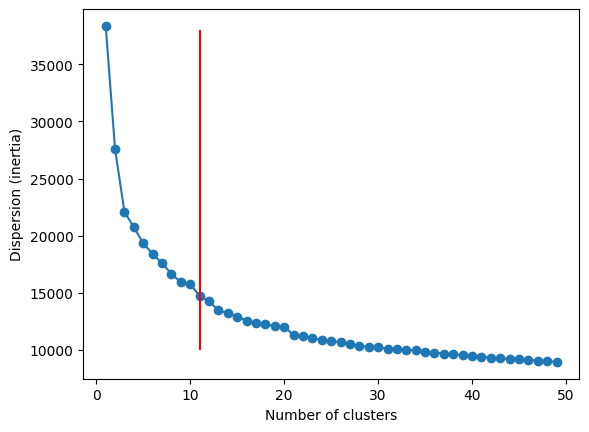

In [29]:
plt.plot(range(1, 50), dispersion, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Dispersion (inertia)')
plt.vlines(11, 10000, 38000, color='red')
plt.show()

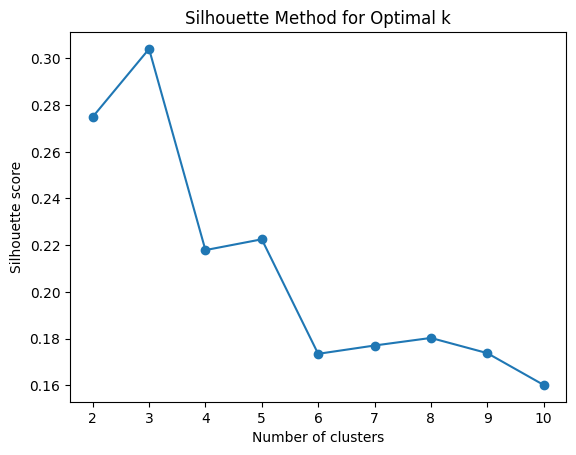

In [24]:
#Plotting the silhouette graph
plot_silhouette(cust_prepoc, max_clusters= 10)

In [25]:
# Create a K-means solution with 100 clusters to then apply the hierarchic clustering to obtain the best number of clusters
cust_copy = cust_prepoc.copy()
kmeans = KMeans(n_clusters=100, random_state=0).fit(cust_prepoc)
cust_copy['cluster_kmeans'] = kmeans.predict(cust_prepoc)

In [26]:
#From the dataset created above (that is a copy of the one after preprocessing) group by centroid 
#so we get the average per centroid to use in the agglomerative clustering

agg_knn = cust_copy.groupby("cluster_kmeans").mean()

In [27]:
# Create the hierarchical algorithm to find the best number of clusters
agg_clust = AgglomerativeClustering(linkage='ward', distance_threshold=0, n_clusters=None).fit(agg_knn)

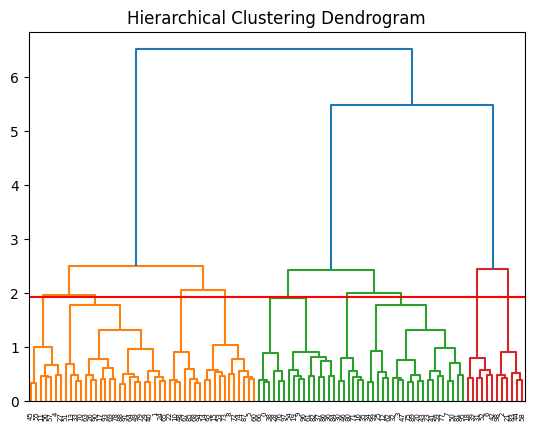

In [28]:
fig, ax = plt.subplots()
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(agg_clust, truncate_mode="level", p=50)
plt.axhline(y = 1.925, color = 'r', linestyle = '-')
plt.show()

In [30]:
kmeans_final = KMeans(n_clusters = 11, random_state=0).fit(cust_prepoc)
cust_prepoc["kmeans_cluster"] = kmeans_final.predict(cust_prepoc)

In [31]:
cust_prepoc.head()

kids_home  teens_home  number_complaints  \
customer_id                                             
39634         0.111111    0.166667           0.111111   
43460         0.111111    0.000000           0.111111   
23937         0.000000    0.166667           0.111111   
2431          0.000000    0.000000           0.000000   
10090         0.000000    0.000000           0.000000   

             distinct_stores_visited  lifetime_spend_groceries  \
customer_id                                                      
39634                       0.142857                  0.689440   
43460                       0.142857                  0.188875   
23937                       0.285714                  0.116639   
2431                        0.000000                  0.407691   
10090                       0.000000                  0.026250   

             lifetime_spend_electronics  typical_hour  \
customer_id                                             
39634                          0.334038      0.611111   
43460                          0.062709      0.111111   
23937                          0.191463      0.222222   
2431                           0.009731      0.611111   
10090                          0.026795      0.766667   

             lifetime_spend_vegetables  lifetime_spend_nonalcohol_drinks  \
customer_id                                                                
39634                         0.229167                          0.271583   
43460                         0.162879                          0.168165   
23937                         0.142519                          0.383094   
2431                          0.072443                          0.113309   
10090                         0.003788                          0.014838   

             lifetime_spend_alcohol_drinks  ...  lifetime_spend_videogames  \
customer_id                                 ...                              
39634                             0.185229  ...                   0.732232   
43460                             0.239049  ...                   0.190759   
23937                             0.340012  ...                   0.279087   
2431                              0.011786  ...                   0.000000   
10090                             0.556472  ...                   0.041381   

             lifetime_spend_petfood  lifetime_total_distinct_products  \
customer_id                                                             
39634                      0.128291                          0.009029   
43460                      0.101398                          0.724041   
23937                      0.102980                          0.361738   
2431                       0.211012                          0.019752   
10090                      0.003266                          0.001129   

             percentage_of_products_bought_promotion  year_first_transaction  \
customer_id                                                                    
39634                                       0.328503                0.500000   
43460                                       0.408523                0.642857   
23937                                       0.366693                0.464286   
2431                                        0.414270                0.392857   
10090                                       0.393475                1.000000   

             latitude  longitude       Age  customer_gender_male  \
customer_id                                                        
39634        0.397470   0.478999  0.596774                   1.0   
43460        0.636523   0.413765  0.225806                   0.0   
23937        0.236664   0.389840  0.532258                   0.0   
2431         0.808462   0.472062  0.967742                   0.0   
10090        0.704482   0.323561  0.000000                   1.0   

             kmeans_cluster  
customer_id                  
39634                     6  
43460                     0  


# SOM clustering

In [32]:
cust_prepoc_array = np.array(cust_prepoc.iloc[:, :-1])

In [33]:
som = MiniSom(
    5,
    3,
    cust_prepoc.iloc[:, :-1].shape[1],
    sigma=0.3,
    learning_rate=0.7,
    neighborhood_function='gaussian',
    random_seed=0
    )

In [34]:
np.random.seed(0)

num_iterations = 1000

q_errors = []
for i in range(1, num_iterations):
    som.train_batch(data = cust_prepoc_array, num_iteration= i)
    q_errors.append(som.quantization_error(cust_prepoc_array))

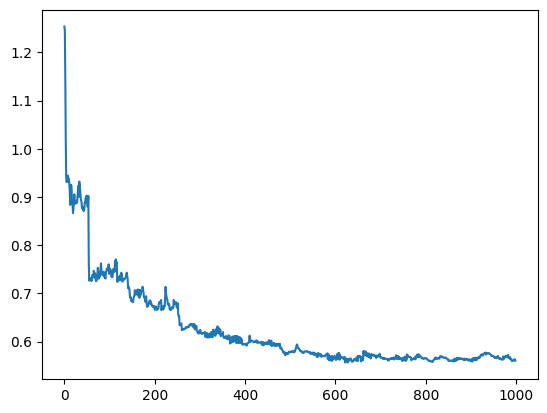

In [35]:
plt.plot(q_errors)

In [36]:
som.train(cust_prepoc_array, 600)
cust_prepoc['winner_node'] = (
    [som.winner(cust_prepoc_array[i]) for i in range(0, len(cust_prepoc_array))]
)

In [37]:
cust_prepoc["winner_node"].unique()

array([(0, 0), (0, 2), (3, 1), (3, 0), (0, 1), (1, 0), (1, 2), (4, 1),
       (4, 2), (2, 1), (4, 0), (3, 2), (2, 2), (1, 1), (2, 0)],
      dtype=object)

In [38]:
dict = {}
i = 0
lt = []
for ele in cust_prepoc["winner_node"]:
    if ele in dict:
        lt.append(dict[ele]) 
    else:
        dict[ele] = i
        lt.append(dict[ele])
        i += 1

In [39]:
cust_prepoc["winner_node"] = pd.Series(lt)

In [40]:
cust_prepoc

kids_home  teens_home  number_complaints  \
customer_id                                             
39634         0.111111    0.166667           0.111111   
43460         0.111111    0.000000           0.111111   
23937         0.000000    0.166667           0.111111   
2431          0.000000    0.000000           0.000000   
10090         0.000000    0.000000           0.000000   
...                ...         ...                ...   
48487         0.111111    0.166667           0.000000   
24856         0.111111    0.166667           0.111111   
21373         0.000000    0.000000           0.000000   
19527         0.111111    0.000000           0.111111   
5120          0.222222    0.000000           0.222222   

             distinct_stores_visited  lifetime_spend_groceries  \
customer_id                                                      
39634                       0.142857                  0.689440   
43460                       0.142857                  0.188875   
23937                       0.285714                  0.116639   
2431                        0.000000                  0.407691   
10090                       0.000000                  0.026250   
...                              ...                       ...   
48487                       0.000000                  0.270752   
24856                       0.000000                  0.423245   
21373                       0.000000                  0.228194   
19527                       0.000000                  0.116677   
5120                        0.000000                  0.258700   

             lifetime_spend_electronics  typical_hour  \
customer_id                                             
39634                          0.334038      0.611111   
43460                          0.062709      0.111111   
23937                          0.191463      0.222222   
2431                           0.009731      0.611111   
10090                          0.026795      0.766667   
...                                 ...           ...   
48487                          0.295821      0.611111   
24856                          0.540121      0.333333   
21373                          0.011329      0.333333   
19527                          0.019978      0.000000   
5120                           0.073050      0.222222   

             lifetime_spend_vegetables  lifetime_spend_nonalcohol_drinks  \
customer_id                                                                
39634                         0.229167                          0.271583   
43460                         0.162879                          0.168165   
23937                         0.142519                          0.383094   
2431                          0.072443                          0.113309   
10090                         0.003788                          0.014838   
...                                ...                               ...   
48487                         0.321023                          0.333183   
24856                         0.285038                          0.250450   
21373                         0.136837                          0.188849   
19527                         0.410038                          0.165917   
5120                          0.126894                          0.296313   

             lifetime_spend_alcohol_drinks  ...  lifetime_spend_petfood  \
customer_id                                 ...                           
39634                             0.185229  ...                0.128291   
43460                             0.239049  ...                0.101398   
23937                             0.340012  ...                0.102980   
2431                              0.011786  ...                0.211012   
10090                             0.556472  ...                0.003266   
...                                    ...  ...                     ...   
48487                             0.125516  ...                0.143499   
24856 

## DBScan

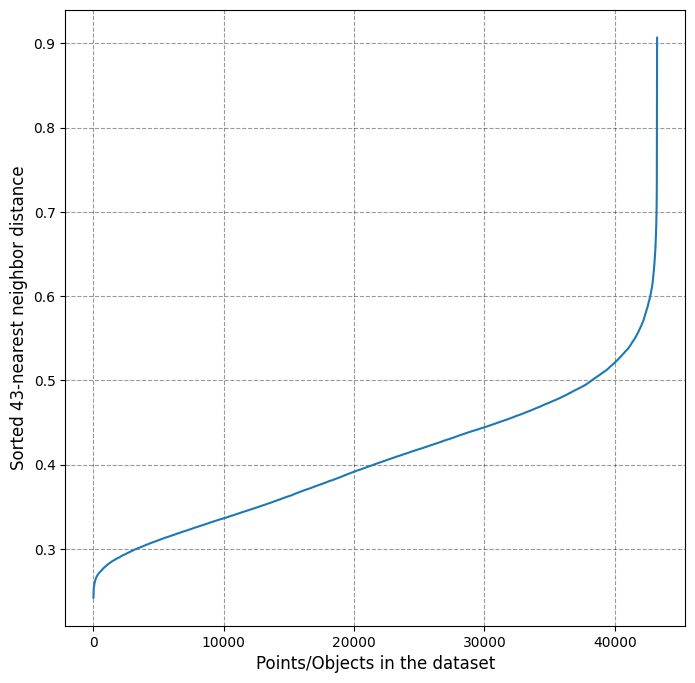

In [41]:
k = 2 * cust_prepoc.iloc[:, :-2].shape[-1] - 1 # k=2*{dim(dataset)} - 1
get_kdist_plot(X=cust_prepoc.iloc[:, :-2], k=k)

In [42]:
cust_prepoc['dbscan_clustering'] = DBSCAN(
    eps=0.58, min_samples=k
    ).fit_predict(cust_prepoc.iloc[:, :-2])

In [43]:
cust_prepoc['dbscan_clustering'].value_counts()

dbscan_clustering
 1    21708
 0    21515
-1       20
Name: count, dtype: int64

## UMAP

In [44]:
umap_object = umap.UMAP(n_neighbors=100, min_dist=0.7, random_state=0)

In [45]:
cust_prepoc = cust_prepoc.sort_index()

In [46]:
umap_embedding = umap_object.fit_transform(cust_prepoc.iloc[:, :-3])

C:\Users\joaof\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


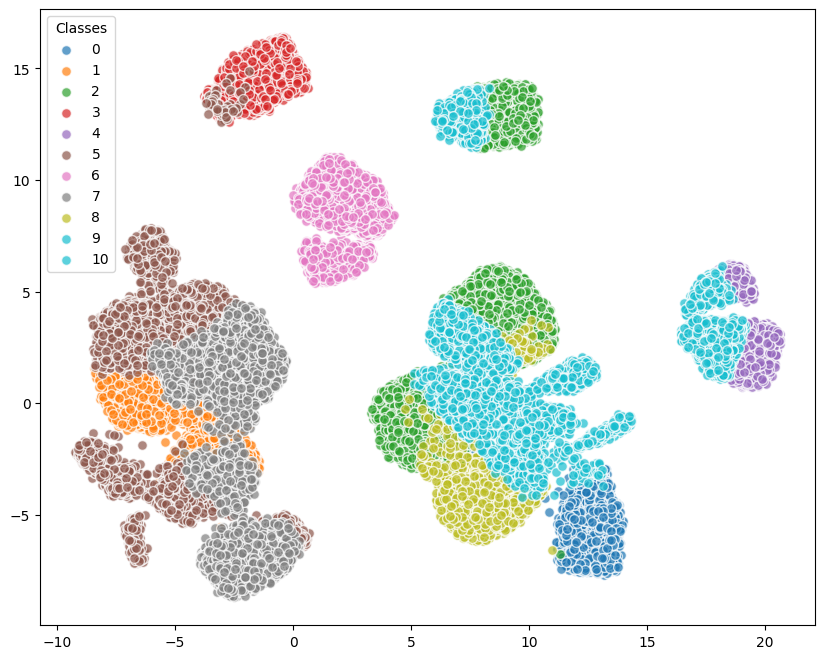

In [47]:
visualize_dimensionality_reduction_umap(umap_embedding, cust_prepoc.iloc[:,-3].sort_index())

In [48]:
umap_object_2 = umap.UMAP(n_neighbors=100, min_dist=0.7, random_state=0)

In [49]:
umap_embedding_2 = umap_object_2.fit_transform(cust_prepoc.iloc[:, :-3])

C:\Users\joaof\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


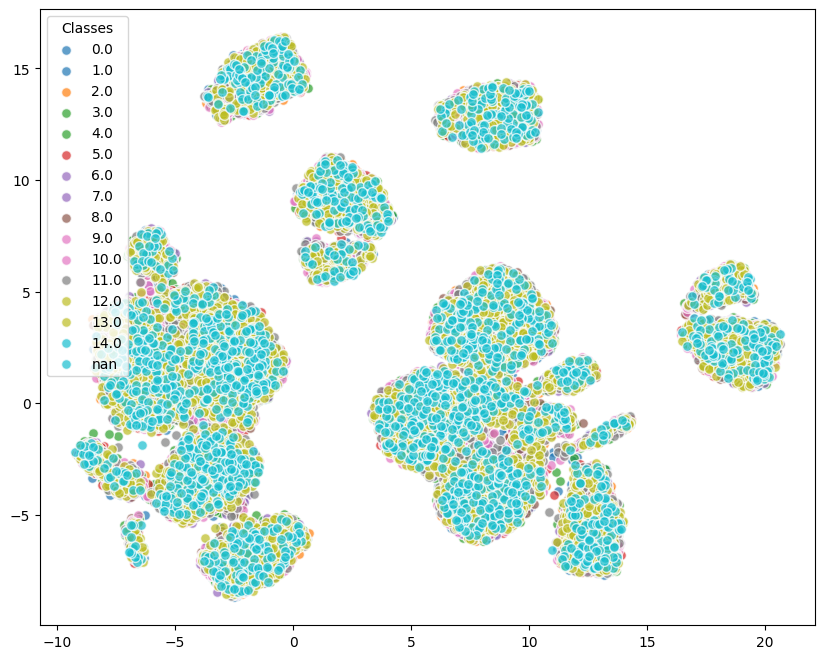

In [50]:
visualize_dimensionality_reduction_umap(umap_embedding_2, cust_prepoc.iloc[:,-2].sort_index())

In [51]:
umap_object_3 = umap.UMAP(n_neighbors=100, min_dist=0.5, random_state=0)

In [52]:
umap_embedding_3 = umap_object_3.fit_transform(cust_prepoc.iloc[:, :-3])

C:\Users\joaof\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


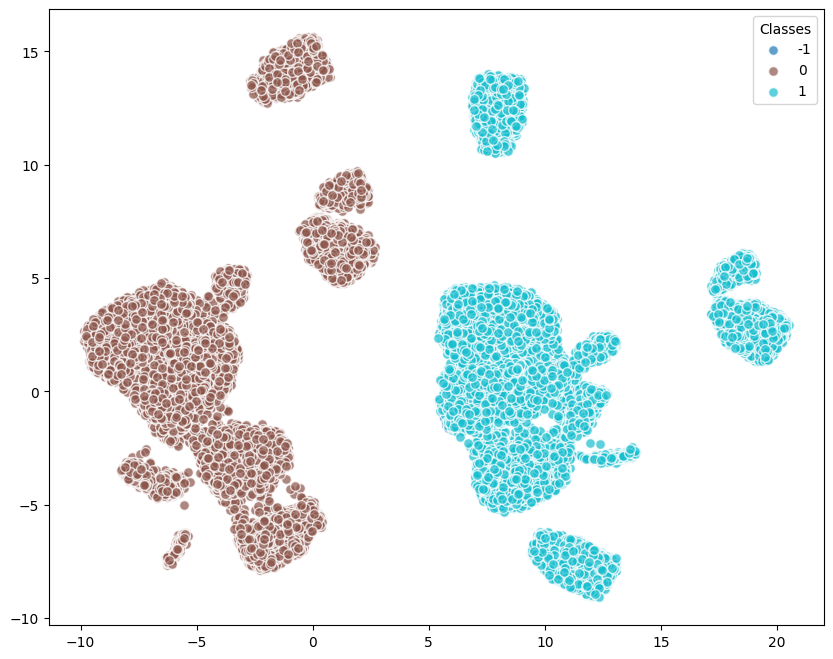

In [53]:
visualize_dimensionality_reduction_umap(umap_embedding_3, cust_prepoc.iloc[:,-1].sort_index())

# Analysis of clusters

In [54]:
cust_kmeans_clusters = cust_prepoc[["kmeans_cluster"]]

In [55]:
cust_kmeans_clusters

kmeans_cluster
customer_id                
1                         2
2                         2
3                         4
4                        10
5                         7
...                     ...
49996                     2
49997                     1
49998                     5
49999                     0
50000                     2

[43243 rows x 1 columns]

In [56]:
og_cluster = customer_info.merge(cust_kmeans_clusters, on='customer_id', how= "left")

In [57]:
og_cluster["kmeans_cluster"] = og_cluster["kmeans_cluster"].fillna(8)

In [58]:
og_cluster.columns

Index(['customer_name', 'customer_birthdate', 'kids_home', 'teens_home',
       'number_complaints', 'distinct_stores_visited',
       'lifetime_spend_groceries', 'lifetime_spend_electronics',
       'typical_hour', 'lifetime_spend_vegetables',
       'lifetime_spend_nonalcohol_drinks', 'lifetime_spend_alcohol_drinks',
       'lifetime_spend_meat', 'lifetime_spend_fish', 'lifetime_spend_hygiene',
       'lifetime_spend_videogames', 'lifetime_spend_petfood',
       'lifetime_total_distinct_products',
       'percentage_of_products_bought_promotion', 'year_first_transaction',
       'loyalty_card_number', 'latitude', 'longitude', 'Age', 'loyalty_card',
       'customer_gender_male', 'kmeans_cluster'],
      dtype='object')

In [59]:
mean_clusters = og_cluster.groupby("kmeans_cluster").agg({
    'kids_home': np.mean,
    'teens_home': np.mean,
    'number_complaints': np.mean,
    'distinct_stores_visited': np.mean,
    'lifetime_spend_groceries': np.mean,
    'lifetime_spend_electronics': np.mean,
    'typical_hour': np.mean,
    'lifetime_spend_vegetables': np.mean,
    'lifetime_spend_nonalcohol_drinks': np.mean,
    'lifetime_spend_alcohol_drinks': np.mean,
    'lifetime_spend_meat': np.mean,
    'lifetime_spend_fish': np.mean,
    'lifetime_spend_hygiene': np.mean,
    'lifetime_spend_videogames': np.mean,
    'lifetime_spend_petfood': np.mean,
    'lifetime_total_distinct_products': np.mean,
    'percentage_of_products_bought_promotion': np.mean,
    'year_first_transaction': np.mean,
    'loyalty_card_number': np.mean,
    'latitude': np.mean,
    'longitude': np.mean,
    'Age': np.mean,
    'loyalty_card': np.mean,
    'customer_gender_male': np.mean,
})


C:\Users\joaof\AppData\Local\Temp\ipykernel_4740\199508456.py:1: FutureWarning: The provided callable <function mean at 0x0000019C7E3CDF80> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  mean_clusters = og_cluster.groupby("kmeans_cluster").agg({


In [60]:
mean_clusters

kids_home  teens_home  number_complaints  \
kmeans_cluster                                             
0.0              1.052904    0.855761           0.999602   
1.0              1.913239    1.230909           0.795860   
2.0              0.637753    0.588651           0.724869   
3.0              0.000000    0.014595           0.488511   
4.0              1.001415    0.998558           0.491827   
5.0              0.864310    0.645409           0.554305   
6.0              1.002163    0.997814           0.491513   
7.0              0.903989    0.943486           0.976013   
8.0              2.823612    1.825099           0.951418   
9.0              1.002155    0.991298           0.527496   
10.0             0.594590    0.459060           0.498060   

                distinct_stores_visited  lifetime_spend_groceries  \
kmeans_cluster                                                      
0.0                            1.968306               4976.506304   
1.0                            1.325110               3706.740373   
2.0                            1.881515               4105.832518   
3.0                            1.000000              10217.807353   
4.0                            1.383954              13838.043417   
5.0                            1.699053               3243.770656   
6.0                            1.383938              14045.366809   
7.0                            2.467413               3597.020163   
8.0                            1.131519               5852.743696   
9.0                            1.402206              14127.153627   
10.0                           1.710984               3803.444059   

                lifetime_spend_electronics  typical_hour  \
kmeans_cluster                                             
0.0                            2098.534673      9.393804   
1.0                            1103.867791     16.836788   
2.0                             334.922440     12.435600   
3.0                             160.282843     11.791943   
4.0                            8122.139356     13.460633   
5.0                            1348.459368     14.057026   
6.0                            8115.167735     13.597037   
7.0                            1183.130671      9.981273   
8.0                            1738.151288     17.694959   
9.0                            8114.375533     13.913653   
10.0                           1183.636947     14.018432   

                lifetime_spend_vegetables  lifetime_spend_nonalcohol_drinks  \
kmeans_cluster                                                                
0.0                            306.285714                        596.212766   
1.0                            668.905168                        407.422005   
2.0                            499.446770                        364.145341   
3.0                            195.032663                        499.644118   
4.0                            501.054402                        601.637955   
5.0                            457.207900                        381.161170   
6.0                            499.134978                        596.588319   
7.0                            300.989538                        456.749128   
8.0                            494.347704                        477.676919   
9.0                            498.978817                        591.958037   
10.0                           428.436148                        374.448916   

                lifetime_spend_alcohol_drinks  ...  lifetime_spend_petfood  \
kmeans_cluster                                 ...                           
0.0                                980.107565  ...             1941.107171   
1.0                                270.649867  ...              729.675067   
2.0                                230.362945  ...             2523.043602   
3.0                                 40.501961  ...            10181.584314   
4.0                               1006.526611  ...          

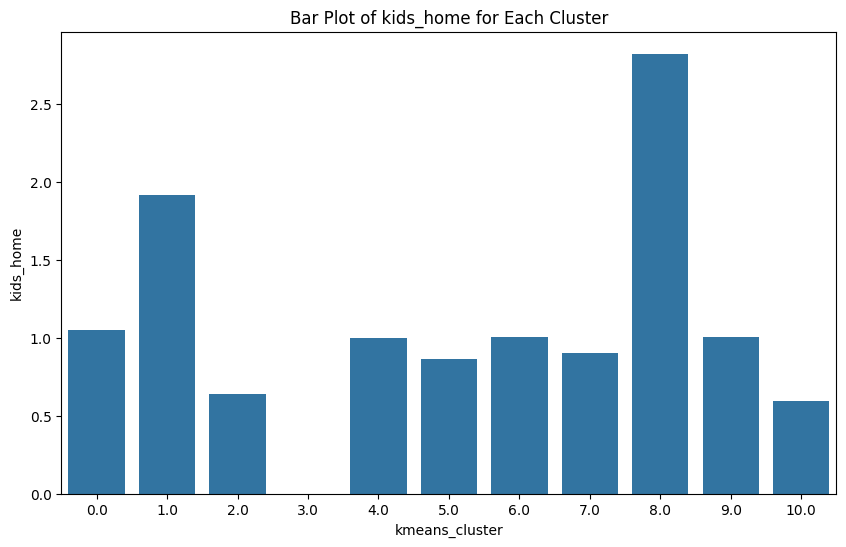

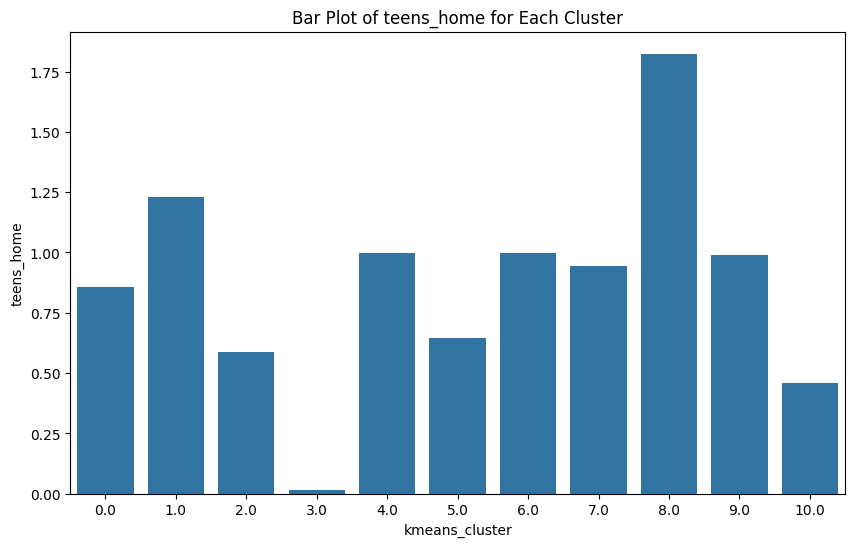

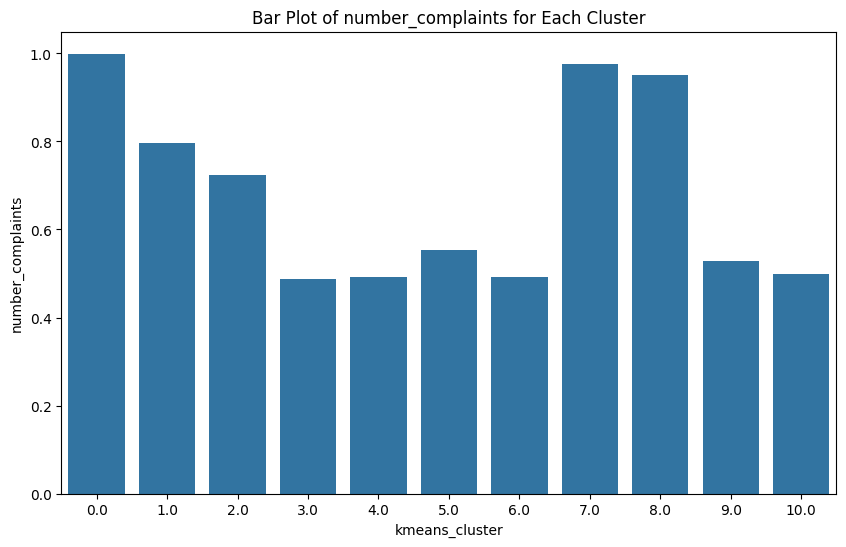

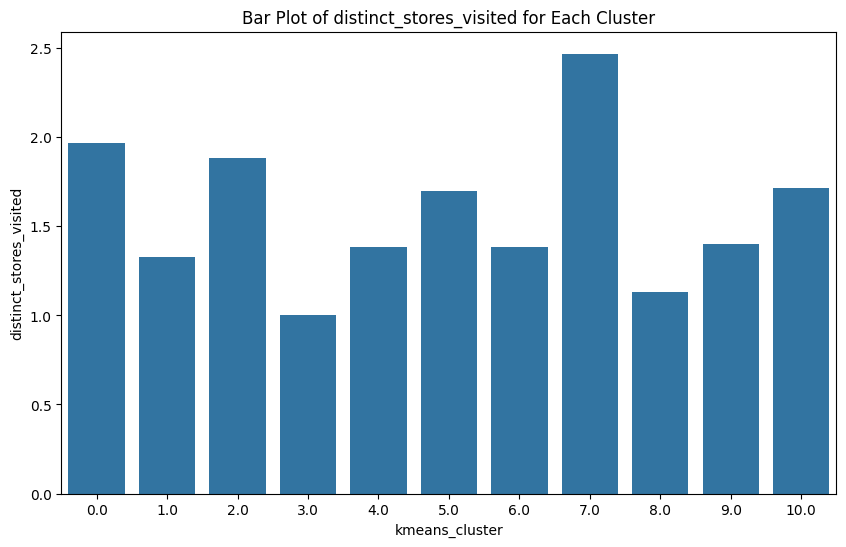

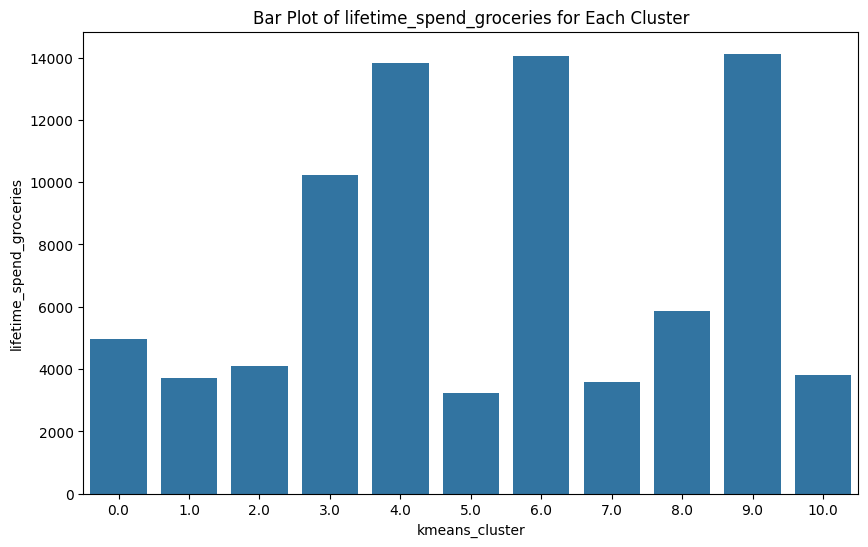

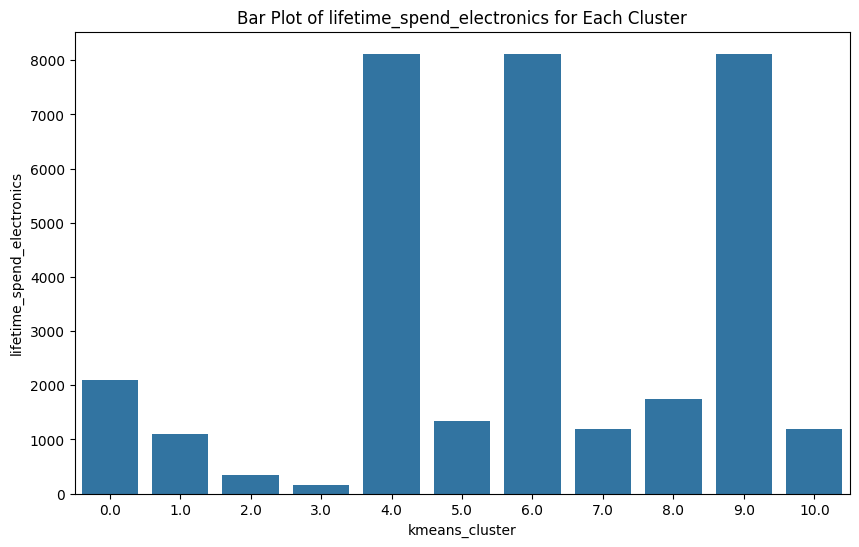

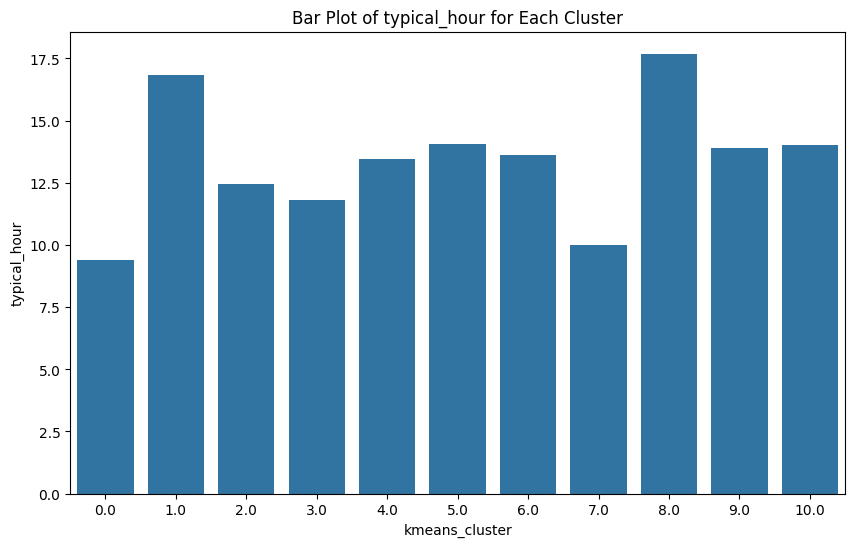

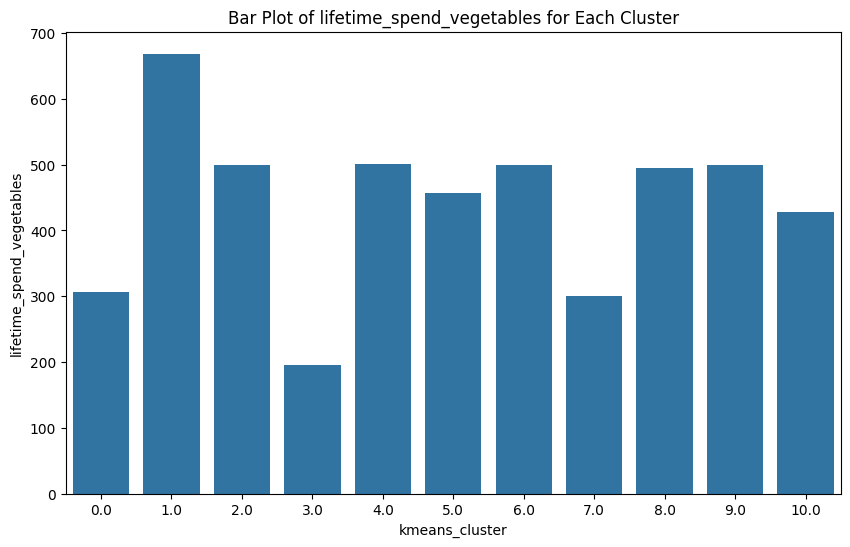

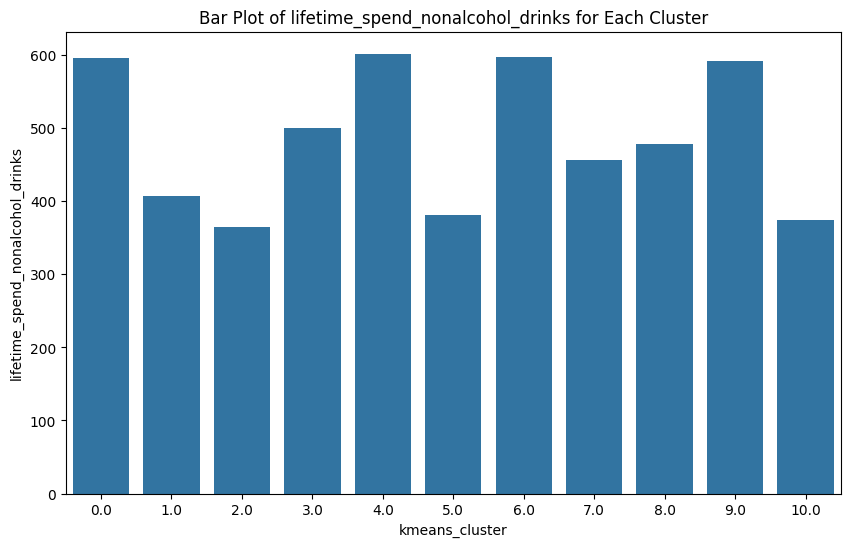

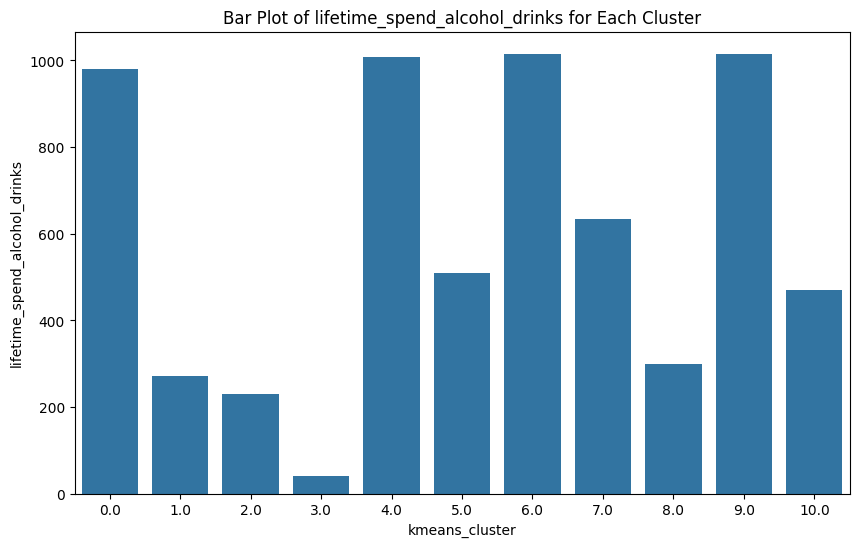

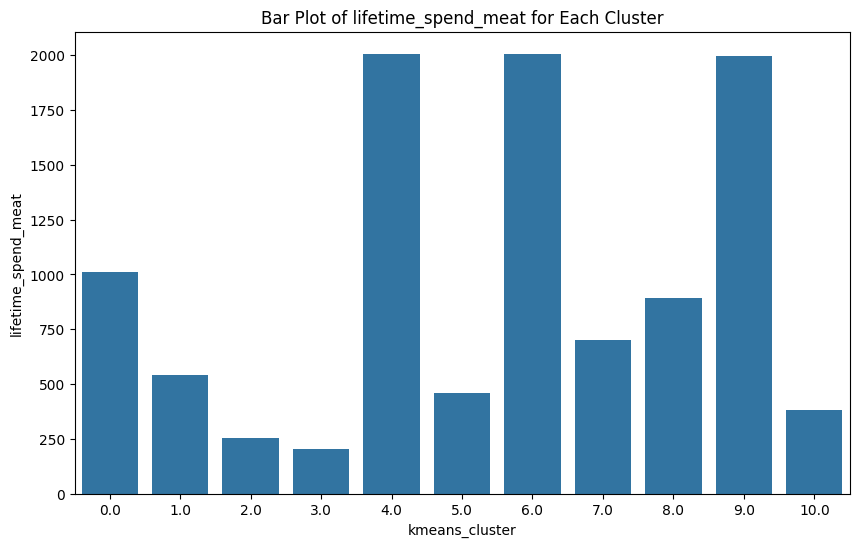

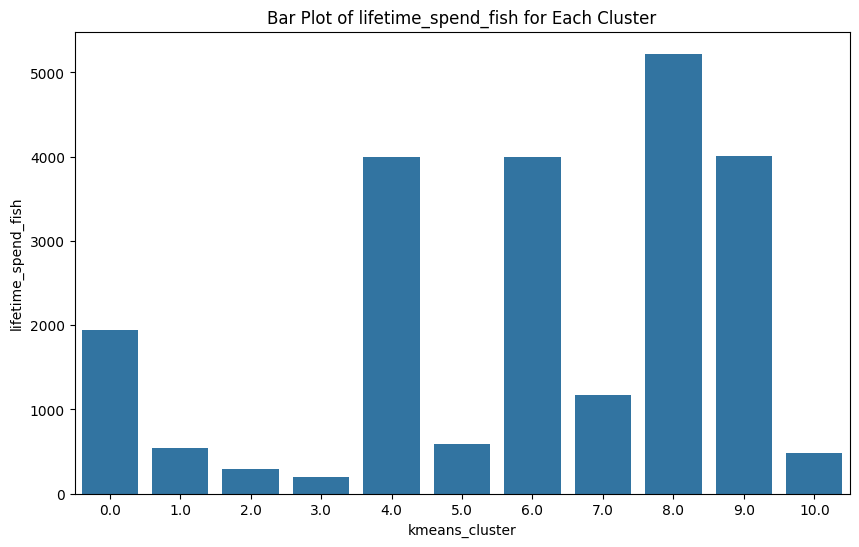

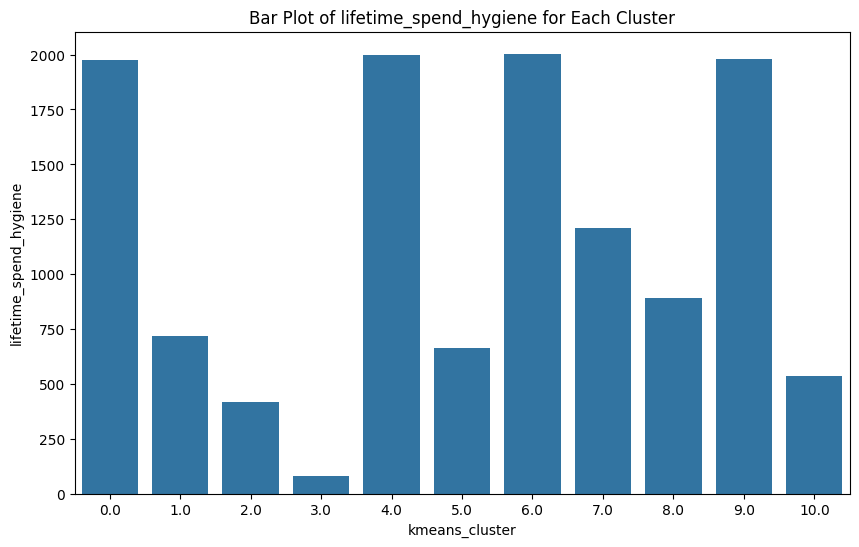

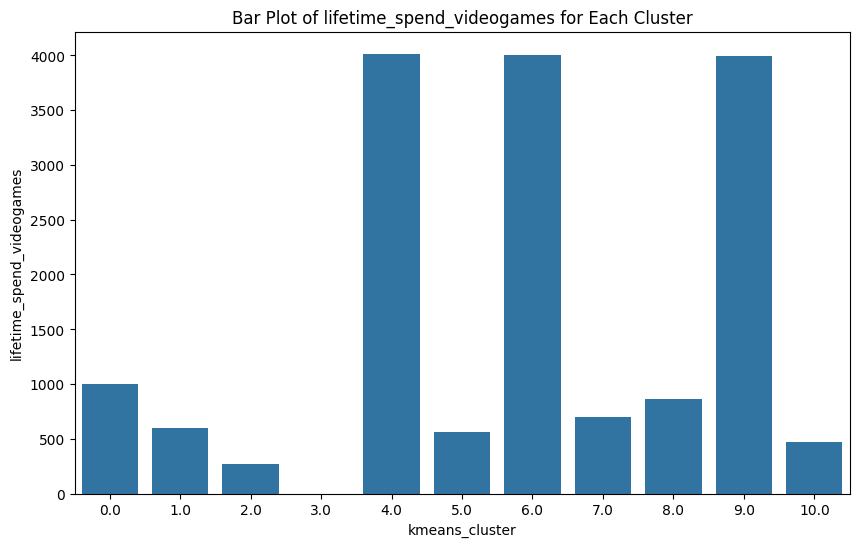

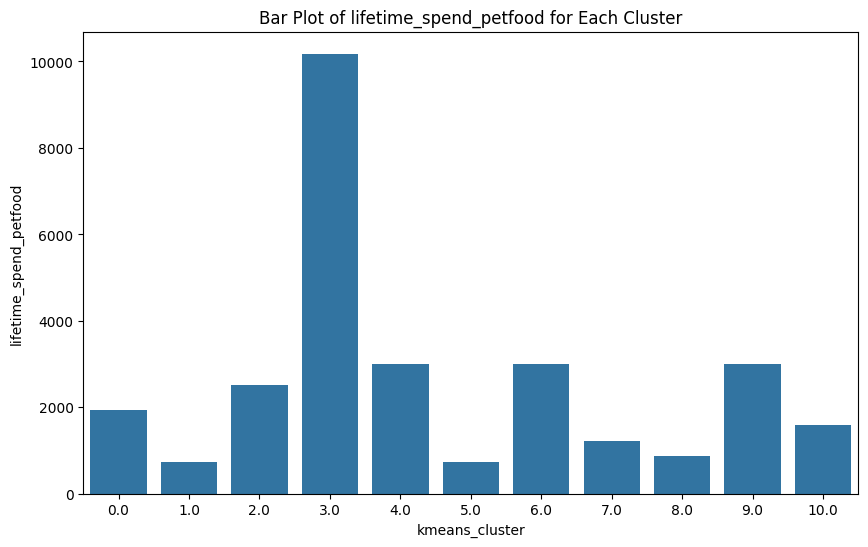

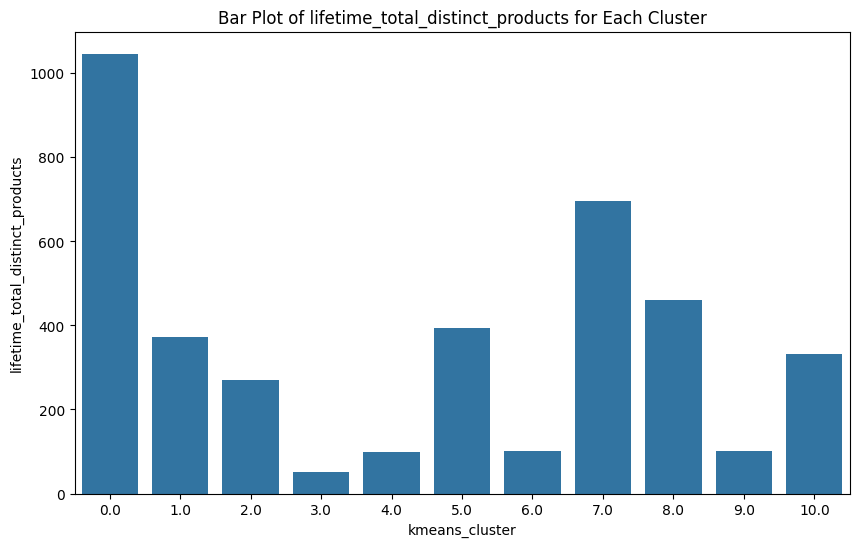

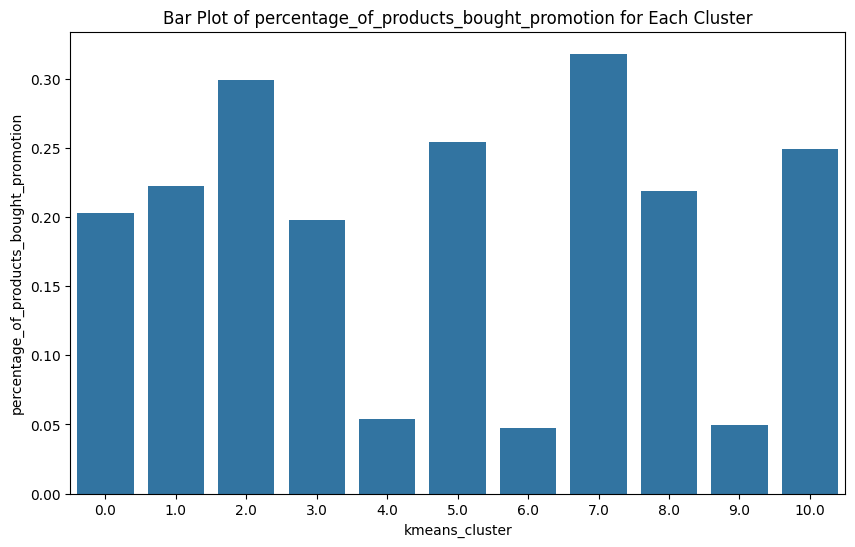

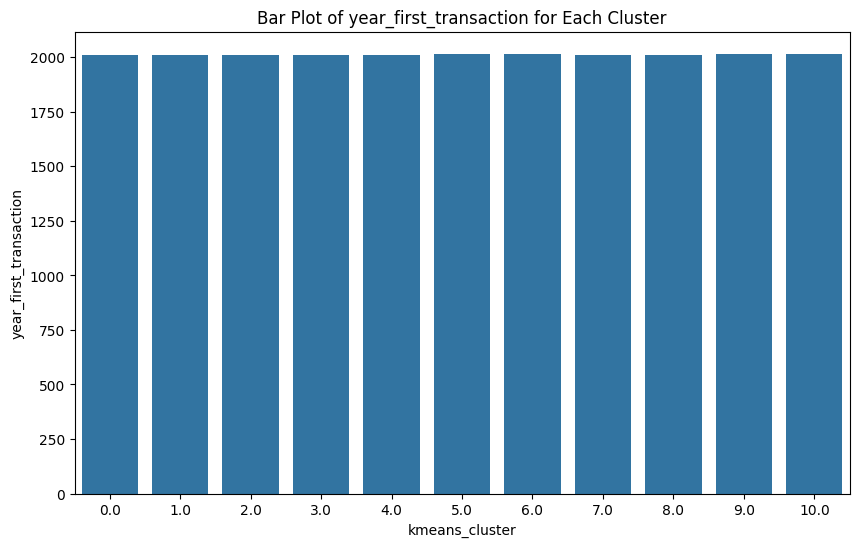

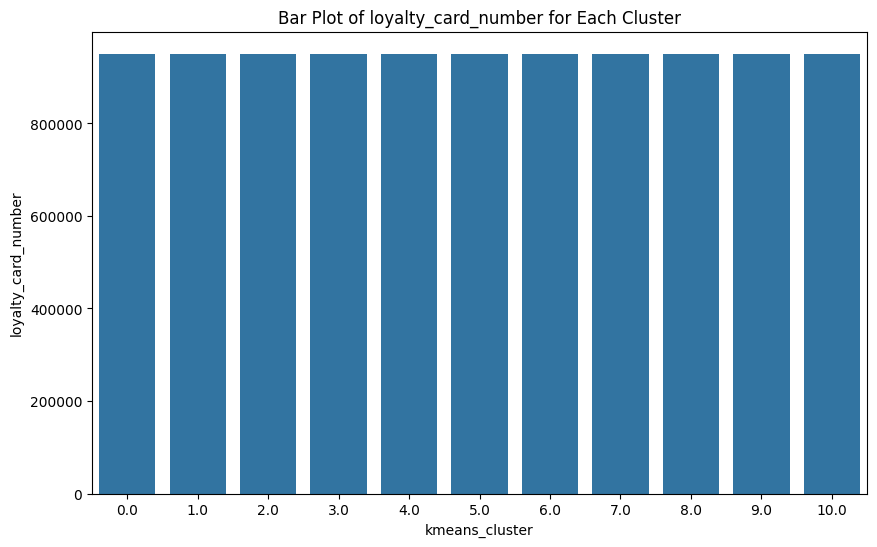

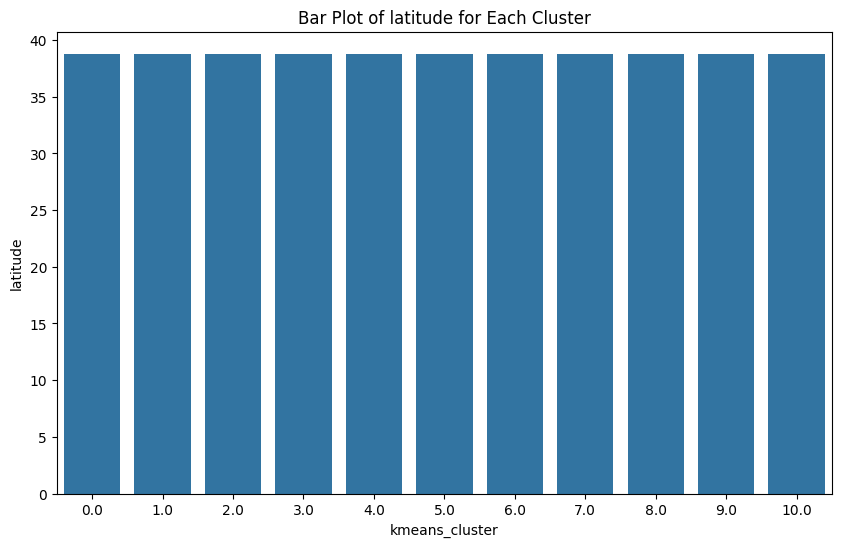

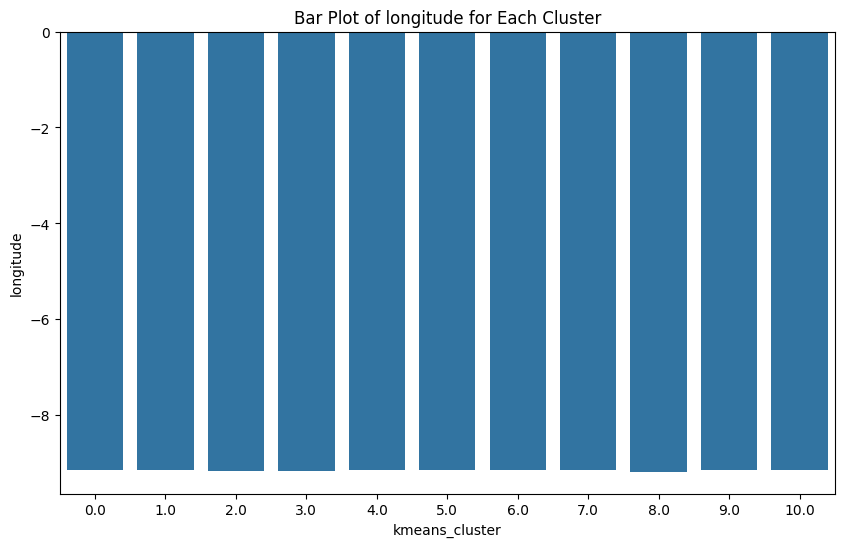

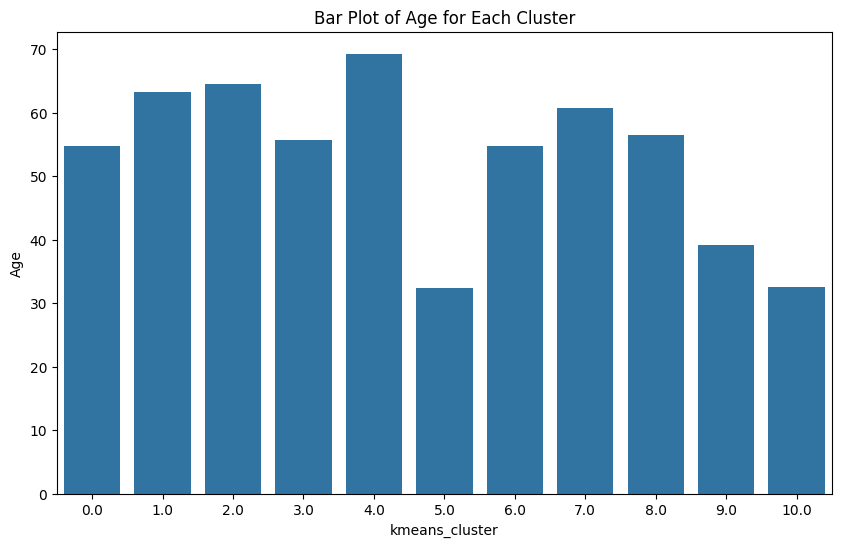

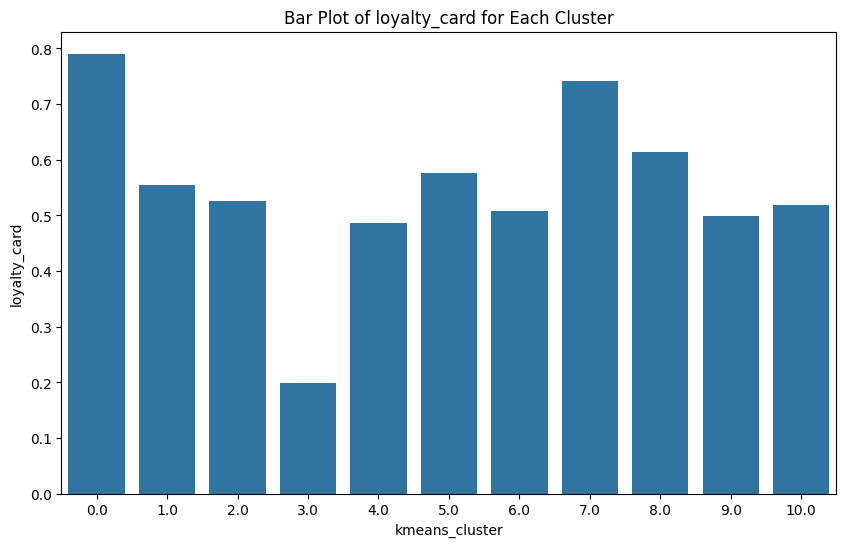

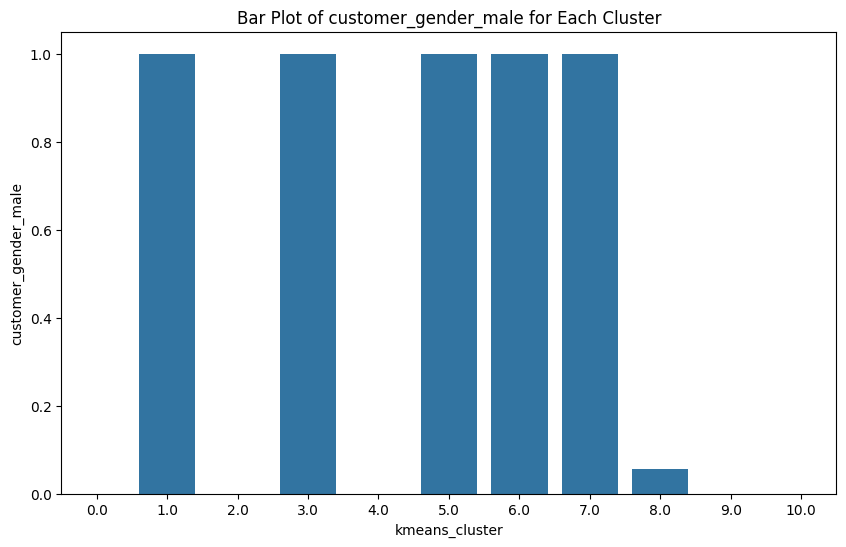

In [61]:
# Bar plots for each variable
for column in mean_clusters.columns:
        plt.figure(figsize=(10, 6))
        sns.barplot(x=mean_clusters.index, y=column, data=mean_clusters)
        plt.title(f'Bar Plot of {column} for Each Cluster')
        plt.show()

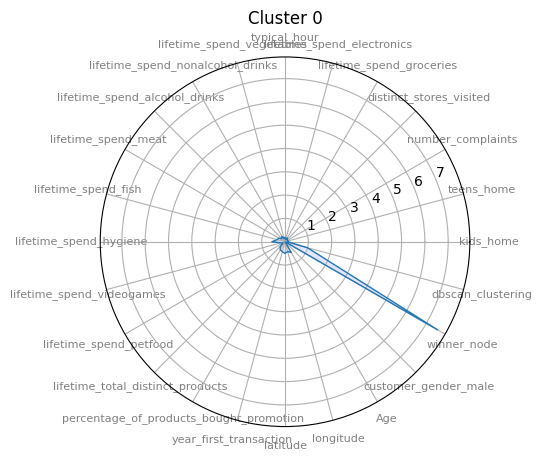

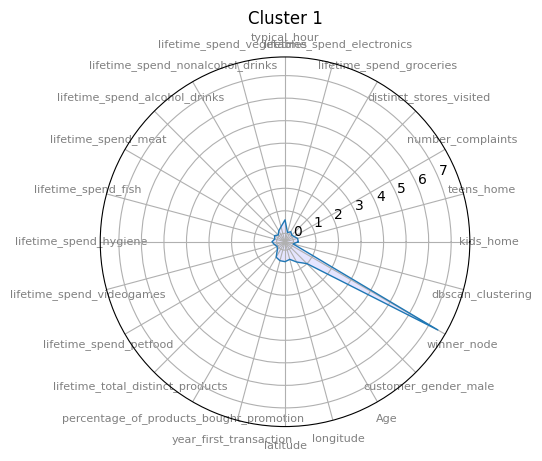

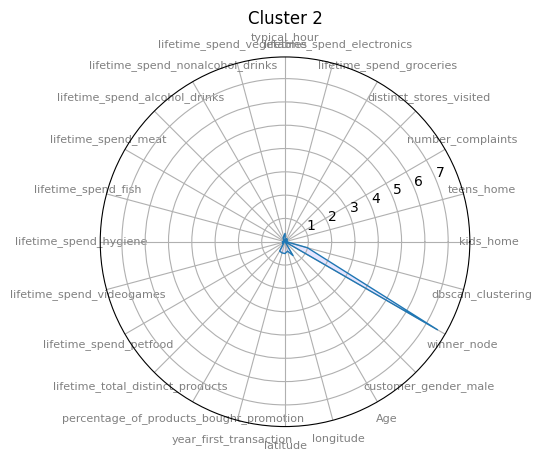

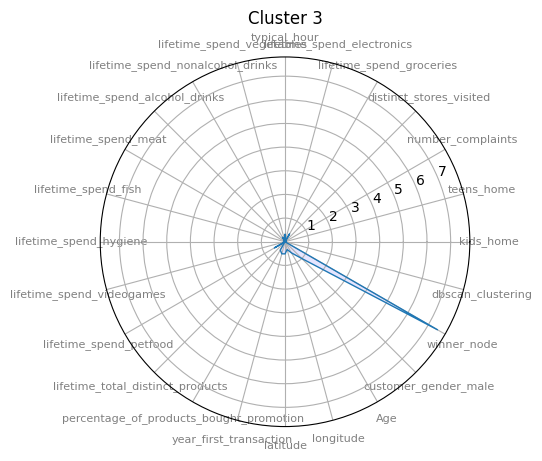

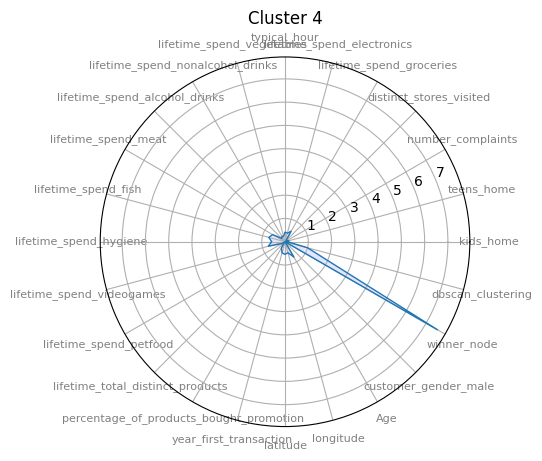

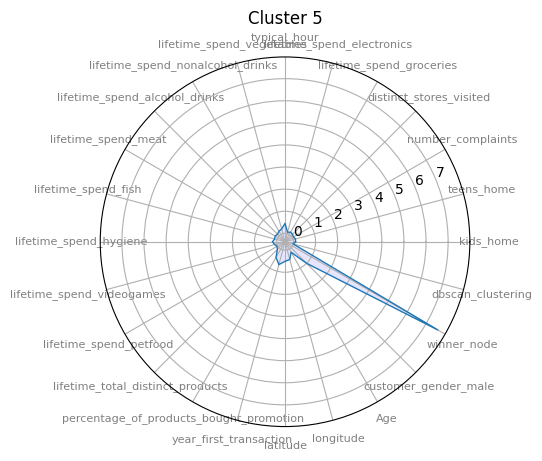

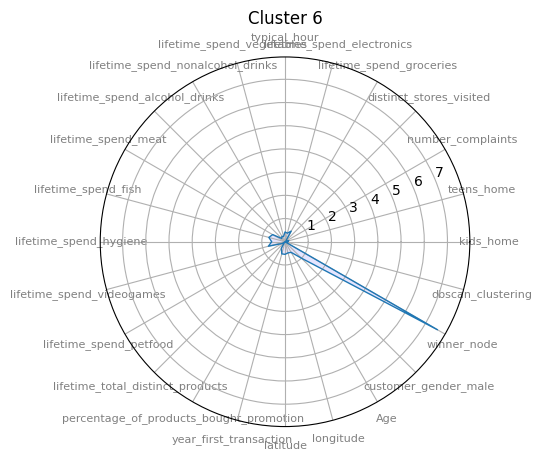

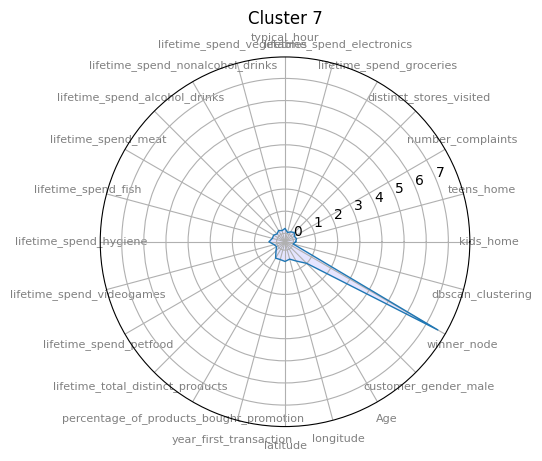

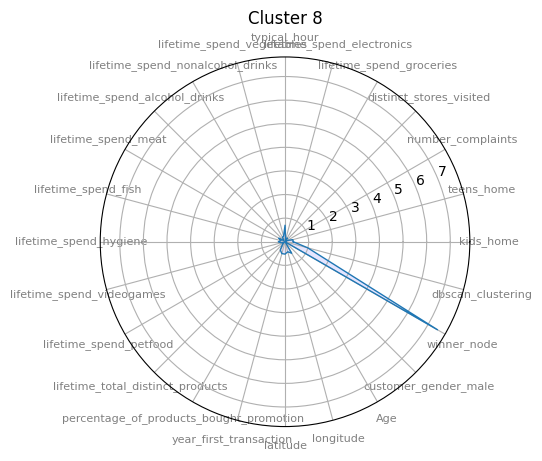

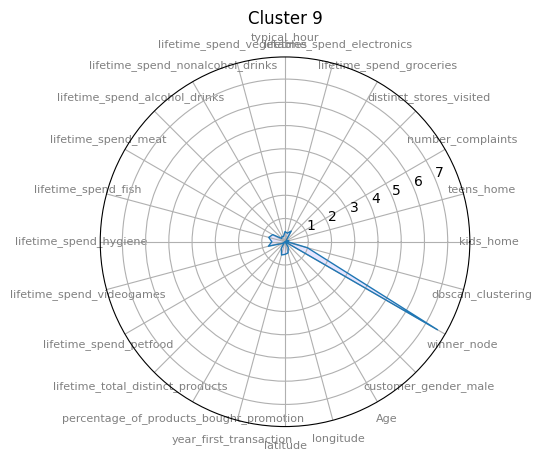

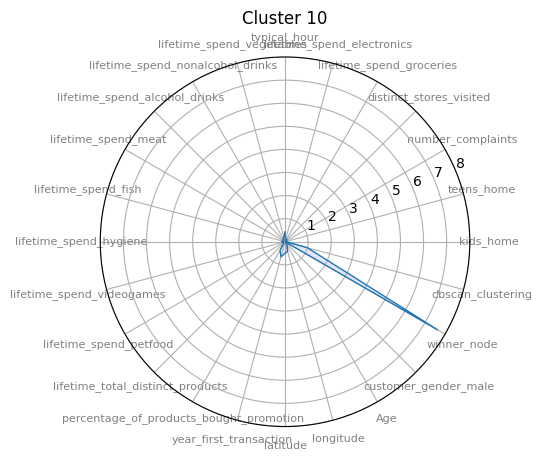

In [62]:
mean_standard_clusters = cust_prepoc.iloc[:-2].groupby("kmeans_cluster").mean()

# Select the columns to be visualized
categories = mean_standard_clusters.columns.tolist()

# Create a radar chart for each cluster
for cluster in mean_standard_clusters.index.tolist():
    create_radar_chart(mean_standard_clusters, cluster, categories)
